In [53]:
# Tế bào 1: Import, Cấu hình và Tải Dữ liệu Nguồn
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

In [2]:

pd.options.display.float_format = '{:.2f}'.format
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')
sns.set_context("notebook", font_scale=1.2)

print("--- Tải Dữ liệu ---")
BASE_DATA_PATH = os.path.expanduser('~/Desktop/')
SR_LEGACY_PATH = os.path.join(BASE_DATA_PATH, 'FoodData_Central_sr_legacy_food_csv_2018-04')
FOUNDATION_PATH = os.path.join(BASE_DATA_PATH, 'FoodData_Central_foundation_food_csv_2025-04-24')
FOOD_DOT_COM_PATH = os.path.join(BASE_DATA_PATH, 'Food.com Recipes and Interactions')

try:
    # Tải USDA
    sr_food_df = pd.read_csv(os.path.join(SR_LEGACY_PATH, 'food.csv'), usecols=['fdc_id', 'description'])
    sr_food_nutrient_df = pd.read_csv(os.path.join(SR_LEGACY_PATH, 'food_nutrient.csv'), usecols=['fdc_id', 'nutrient_id', 'amount'])
    foundation_food_df = pd.read_csv(os.path.join(FOUNDATION_PATH, 'food.csv'), usecols=['fdc_id', 'description'])
    foundation_food_nutrient_df = pd.read_csv(os.path.join(FOUNDATION_PATH, 'food_nutrient.csv'), usecols=['fdc_id', 'nutrient_id', 'amount'])
    nutrient_df = pd.read_csv(os.path.join(SR_LEGACY_PATH, 'nutrient.csv'), usecols=['id', 'name'])
    # Tải Recipes
    raw_recipes_df = pd.read_csv(os.path.join(FOOD_DOT_COM_PATH, 'RAW_recipes.csv'))
    print(" Tất cả các file nguồn đã được tải thành công.")
except Exception as e:
    print(f" LỖI khi tải file: {e}")

--- Tải Dữ liệu ---
 Tất cả các file nguồn đã được tải thành công.


In [3]:

# --- Verification 1 ---
print("\n--- Verification 1 ---")
print("Initial shapes of loaded dataframes:")
print(f"SR Legacy Foods: food={sr_food_df.shape}, food_nutrient={sr_food_nutrient_df.shape}")
print(f"Foundation Foods: food={foundation_food_df.shape}, food_nutrient={foundation_food_nutrient_df.shape}")
print(f"Nutrient table: {nutrient_df.shape}")


--- Verification 1 ---
Initial shapes of loaded dataframes:
SR Legacy Foods: food=(7793, 2), food_nutrient=(644125, 3)
Foundation Foods: food=(74175, 2), food_nutrient=(155243, 3)
Nutrient table: (474, 2)


In [4]:

# --- Implementation & Verification ---

# === 2.1: Hợp nhất Dữ liệu Thô từ USDA ===
print("--- 2.1: Hợp nhất dữ liệu USDA ---")
combined_food_df = pd.concat([sr_food_df, foundation_food_df], ignore_index=True).drop_duplicates(subset=['fdc_id'])
combined_food_nutrient_df = pd.concat([sr_food_nutrient_df, foundation_food_nutrient_df], ignore_index=True)
print(f"Dữ liệu Food đã hợp nhất: {combined_food_df.shape}")
print(f"Combined nutrient data shape: {combined_food_nutrient_df.shape}")
print("-" * 80)


--- 2.1: Hợp nhất dữ liệu USDA ---
Dữ liệu Food đã hợp nhất: (81968, 2)
Combined nutrient data shape: (799368, 3)
--------------------------------------------------------------------------------


In [5]:

# === 2.2: Lọc, Pivot và Hợp nhất để tạo Bảng Thô ===
print("\n--- 2.2: Tạo Bảng tra cứu thô ---")
NUTRIENT_IDS = {'calories': 1008, 'protein_g': 1003, 'fat_g': 1004, 'carbs_g': 1005, 'fiber_g': 1079, 'sugar_g': 2000}
food_nutrient_filtered_df = combined_food_nutrient_df[combined_food_nutrient_df['nutrient_id'].isin(NUTRIENT_IDS.values())].copy()
nutrient_id_to_col_name = {v: k for k, v in NUTRIENT_IDS.items()}
nutrient_pivot_df = food_nutrient_filtered_df.pivot_table(index='fdc_id', columns='nutrient_id', values='amount', aggfunc='first')
nutrient_flat_df = nutrient_pivot_df.reset_index().rename(columns=nutrient_id_to_col_name)
nutrient_flat_df.columns.name = None
usda_lookup_raw_df = pd.merge(combined_food_df.dropna(subset=['description']), nutrient_flat_df, on='fdc_id', how='inner')
print(f"Bảng tra cứu thô đã tạo. Shape: {usda_lookup_raw_df.shape}")
print("-" * 80)


--- 2.2: Tạo Bảng tra cứu thô ---
Bảng tra cứu thô đã tạo. Shape: (13634, 8)
--------------------------------------------------------------------------------


In [6]:
# Verification
print(f"Shape of raw lookup table after merge: {usda_lookup_raw_df.shape}")
print("First 5 rows of raw lookup table:")
display(usda_lookup_raw_df.head())
print("-" * 60)

Shape of raw lookup table after merge: (13634, 8)
First 5 rows of raw lookup table:


,fdc_id,description,protein_g,fat_g,carbs_g,calories,fiber_g,sugar_g
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",5.88,13.24,41.18,307.00,1.20,5.88
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",4.34,11.27,53.42,330.00,1.40,21.34
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",6.10,3.70,79.80,377.00,NaN,NaN
3,167515,"George Weston Bakeries, Thomas English Muffins",8.00,1.80,46.00,232.00,NaN,NaN
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",6.58,9.22,41.05,273.00,2.20,4.30


------------------------------------------------------------


In [7]:
# Verification
print(f"Shape of food_nutrient table after filtering: {food_nutrient_filtered_df.shape}")
print("Value counts per nutrient:")
print(food_nutrient_filtered_df['nutrient_id'].value_counts())
print("-" * 60)

Shape of food_nutrient table after filtering: (53081, 3)
Value counts per nutrient:
nutrient_id
1004    12352
1079     9435
1003     9169
1005     8145
1008     7928
2000     6052
Name: count, dtype: int64
------------------------------------------------------------


In [9]:
food_nutrient_filtered_df.head()

,fdc_id,nutrient_id,amount
0,167512,1003,5.88
3,167512,1079,1.20
9,167512,1004,13.24
10,167512,1005,41.18
11,167512,1008,307.00


In [10]:
# Verification
print("Pivot and flatten complete.")
print(f"Shape of flattened table: {nutrient_flat_df.shape}")
print("First 5 rows of flattened table (contains NaNs):")
display(nutrient_flat_df.head())
print("-" * 60)

Pivot and flatten complete.
Shape of flattened table: (13634, 7)
First 5 rows of flattened table (contains NaNs):


,fdc_id,protein_g,fat_g,carbs_g,calories,fiber_g,sugar_g
0,167512,5.88,13.24,41.18,307.00,1.20,5.88
1,167513,4.34,11.27,53.42,330.00,1.40,21.34
2,167514,6.10,3.70,79.80,377.00,NaN,NaN
3,167515,8.00,1.80,46.00,232.00,NaN,NaN
4,167516,6.58,9.22,41.05,273.00,2.20,4.30


------------------------------------------------------------


In [11]:

print("\n--- Performing Intelligent Semantic Aggregation ---")

# --- 4.4.1: Xử lý Dữ liệu Lỗi và Nhiễu ---
print("\n--- Cleaning Noisy Data ---")
numeric_cols = list(NUTRIENT_IDS.keys())
# Loại bỏ các hàng có giá trị dinh dưỡng âm (phi vật lý)
initial_rows = len(usda_lookup_raw_df)
for col in numeric_cols:
    usda_lookup_raw_df = usda_lookup_raw_df[usda_lookup_raw_df[col] >= 0]
cleaned_rows = len(usda_lookup_raw_df)
print(f"Removed {initial_rows - cleaned_rows} rows with negative nutritional values.")


--- Performing Intelligent Semantic Aggregation ---

--- Cleaning Noisy Data ---
Removed 7700 rows with negative nutritional values.


In [12]:
# Verification (Before)
print("Min values before cleaning negative values:")
print(usda_lookup_raw_df[numeric_cols].min())

initial_rows = len(usda_lookup_raw_df)
for col in numeric_cols:
    usda_lookup_raw_df = usda_lookup_raw_df[usda_lookup_raw_df[col] >= 0]
print(f"Removed {initial_rows - len(usda_lookup_raw_df)} rows with negative nutritional values.")
# Verification (After)
print("\nMin values after cleaning:")
print(usda_lookup_raw_df[numeric_cols].min())
print("-" * 60)

Min values before cleaning negative values:
calories    0.00
protein_g   0.00
fat_g       0.00
carbs_g     0.00
fiber_g     0.00
sugar_g     0.00
dtype: float64
Removed 0 rows with negative nutritional values.

Min values after cleaning:
calories    0.00
protein_g   0.00
fat_g       0.00
carbs_g     0.00
fiber_g     0.00
sugar_g     0.00
dtype: float64
------------------------------------------------------------


In [28]:
# === 2.3: Xây dựng Hàm Trích xuất Gốc Ngữ nghĩa (HOÀN CHỈNH) ===
print("\n--- 2.3: Định nghĩa Hàm Trích xuất Gốc Ngữ nghĩa ---")
def get_semantic_root_final(description: str) -> str:
    if not isinstance(description, str):
        return ""
        
    # Chuyển về chữ thường và tách các phần bởi dấu phẩy
    parts = [part.strip() for part in description.lower().split(',')]
    
    # TH1: Mô tả ngắn, không có dấu phẩy (ví dụ: 'Hummus')
    if len(parts) == 1:
        # Loại bỏ các phần trong ngoặc đơn
        return re.sub(r'\(.*\)', '', parts[0]).strip()
        
    # TH2: Mô tả có cấu trúc (ví dụ: 'Nuts, almond butter, plain...')
    # Giả định phần thứ 2 là tên chính, phần đầu là danh mục.
    # Chúng ta sẽ ưu tiên lấy phần thứ 2.
    main_name = parts[1]
    
    # Kiểm tra xem phần đầu (danh mục) có phải là một từ chung chung không.
    # Nếu không, nó có thể là một phần quan trọng của tên (ví dụ: 'Beef, ground')
    generic_categories = ['nuts', 'beverages', 'spices and herbs', 'fats and oils', 'sweets']
    if parts[0] not in generic_categories and not parts[0].startswith('babyfood'):
        # Nếu danh mục không chung chung, hãy ghép nó với tên chính
        # Ví dụ: 'Beef, ground' -> 'beef ground'
        main_name = f"{parts[0]} {parts[1]}"
        
    # Loại bỏ các phần mô tả không cần thiết phía sau (ví dụ: 'with salt added')
    main_name = main_name.split(' with ')[0]
    main_name = main_name.split(' without ')[0]
    
    # Loại bỏ các phần trong ngoặc đơn
    main_name = re.sub(r'\(.*\)', '', main_name).strip()
    
    return main_name
print("Hàm 'get_semantic_root_final' đã được định nghĩa.")
print("-" * 80)


--- 2.3: Định nghĩa Hàm Trích xuất Gốc Ngữ nghĩa ---
Hàm 'get_semantic_root_final' đã được định nghĩa.
--------------------------------------------------------------------------------


In [30]:
# Áp dụng hàm mới
usda_lookup_raw_df['semantic_root'] = usda_lookup_raw_df['description'].apply(get_semantic_root_final)

In [31]:
# Verification 
print("Verifying the new root extraction logic:")
display(usda_lookup_raw_df[usda_lookup_raw_df['description'].str.contains('Nuts, almond butter|Beef, ground, 85%|Hummus, commercial', case=False, regex=True)][['description', 'semantic_root']].head())
print("-" * 80)

Verifying the new root extraction logic:


,description,semantic_root
1076,"Nuts, almond butter, plain, without salt added",almond butter
1091,"Nuts, almond butter, plain, with salt added",almond butter
4284,"Beef, ground, 85% lean meat / 15% fat, raw (In...",beef ground
6520,"Beef, ground, 85% lean meat / 15% fat, patty, ...",beef ground
6521,"Beef, ground, 85% lean meat / 15% fat, patty, ...",beef ground


--------------------------------------------------------------------------------


In [32]:
display(usda_lookup_raw_df[usda_lookup_raw_df['description'].str.contains('butter|beef, ground|hummus', case=False, regex=True)][['description', 'semantic_root']].sample(15, random_state=1))

,description,semantic_root
1139,"Beef, ground, 70% lean meat / 30% fat, patty, ...",beef ground
1868,"Pickles, cucumber, sweet, low sodium (includes...",pickles cucumber
409,"Pillsbury Grands, Buttermilk Biscuits, refrige...",pillsbury grands buttermilk biscuits
4948,"Peanut butter, chunky, vitamin and mineral for...",peanut butter chunky
4649,"Beef, ground, unspecified fat content, cooked",beef ground
587,"Creamy dressing, made with sour cream and/or b...",creamy dressing made
1961,"Beef, ground, 70% lean meat / 30% fat, crumble...",beef ground
177,"Candies, MARS SNACKFOOD US, M&M's Peanut Butte...",candies mars snackfood us
1784,"Squash, winter, butternut, cooked, baked, with...",squash winter
5157,"Biscuits, plain or buttermilk, refrigerated do...",biscuits plain or buttermilk


In [33]:
display(usda_lookup_raw_df[usda_lookup_raw_df['description'].str.contains('Nuts, almond butter', case=False)][['description', 'semantic_root']].head())
display(usda_lookup_raw_df[usda_lookup_raw_df['description'].str.contains('Hummus', case=False)][['description', 'semantic_root']].head())

,description,semantic_root
1076,"Nuts, almond butter, plain, without salt added",almond butter
1091,"Nuts, almond butter, plain, with salt added",almond butter


,description,semantic_root
4942,"Hummus, home prepared",hummus home prepared
6777,"Hummus, commercial",hummus commercial


In [34]:

# === 2.4: Tổng hợp Dữ liệu và Dọn dẹp Cuối cùng ===
print("\n--- 2.4: Tổng hợp và Dọn dẹp Bảng tra cứu ---")
usda_lookup_raw_df['semantic_root'] = usda_lookup_raw_df['description'].apply(get_semantic_root_final)
numeric_cols = list(NUTRIENT_IDS.keys())
usda_lookup_raw_df = usda_lookup_raw_df[(usda_lookup_raw_df[numeric_cols].fillna(0) >= 0).all(axis=1)]
usda_lookup_raw_df[numeric_cols] = usda_lookup_raw_df[numeric_cols].replace(0, np.nan)
usda_aggregated_lookup_df = usda_lookup_raw_df.groupby('semantic_root', as_index=False)[numeric_cols].mean()
usda_aggregated_lookup_df.fillna(0, inplace=True)
usda_aggregated_lookup_df = usda_aggregated_lookup_df[usda_aggregated_lookup_df['calories'] > 0].reset_index(drop=True)



--- 2.4: Tổng hợp và Dọn dẹp Bảng tra cứu ---


In [38]:

# --- FINAL VALIDATION (USDA) ---
print("\nBảng tra cứu Dinh dưỡng USDA cuối cùng đã được tạo.")
print(f"Final Shape: {usda_aggregated_lookup_df.shape}")
print("\nKiểm tra 'almond butter':")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['semantic_root'].str.contains('butter', na=False)])
print("\nKiểm tra 'chicken':")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['semantic_root'].str.contains('chicken', na=False)])
print("\nKiểm tra 'fish':")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['semantic_root'].str.contains('fish', na=False)])
print("\nKiểm tra 'vegan':")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['semantic_root'].str.contains('vegetable', na=False)])
display(usda_aggregated_lookup_df.describe())


Bảng tra cứu Dinh dưỡng USDA cuối cùng đã được tạo.
Final Shape: (2352, 7)

Kiểm tra 'almond butter':


,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g
21,almond butter,614.00,20.96,55.50,18.82,10.30,5.35
69,archway home style cookies peanut butter,480.00,9.00,24.28,58.48,2.80,32.55
185,biscuits plain or buttermilk,334.14,7.02,11.64,50.36,1.81,6.89
283,butter,717.00,0.85,81.11,0.06,0.00,0.06
284,butter clarified butter,900.00,0.00,100.00,0.00,0.00,0.00
285,butter light,499.00,3.30,55.10,0.00,0.00,0.00
286,butter oil anhydrous,876.00,0.28,99.48,0.00,0.00,0.00
287,butter replacement,373.00,2.00,1.00,89.00,0.00,5.30
288,butter salted,717.00,0.85,81.11,0.06,0.00,0.06
289,butter whipped,731.00,0.49,78.30,0.00,0.00,0.06



Kiểm tra 'chicken':


,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g
35,applebee's chicken tenders,296.00,19.25,16.15,18.36,1.20,0.39
36,applebee's chicken tenders platter,297.00,19.62,16.24,17.98,1.00,0.36
201,bologna chicken,302.00,10.51,26.51,5.15,0.00,0.00
208,bratwurst chicken,176.00,19.44,10.35,0.00,0.00,0.00
269,burger king chicken strips,292.00,18.20,15.25,20.49,1.30,0.00
...,...,...,...,...,...,...,...
2018,soup vegetable chicken,69.00,5.10,2.00,8.76,0.40,1.42
2105,subway oven roasted chicken sub on white bread,157.00,10.84,3.15,21.35,1.20,2.99
2109,subway sweet onion chicken teriyaki sub on whi...,155.00,10.91,2.37,22.54,1.20,6.06
2141,t.g.i. friday's chicken fingers,327.50,18.39,20.55,17.28,0.85,0.29



Kiểm tra 'fish':


,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g
41,applebee's fish,202.00,13.23,9.14,16.65,0.90,0.51
278,burger king premium fish sandwich,260.00,10.29,12.45,26.69,0.90,3.53
715,crustaceans crayfish,79.50,16.37,1.07,0.00,0.00,0.00
734,denny's fish fillet,234.00,13.75,12.16,17.41,1.00,0.40
832,fast foods fish sandwich,268.00,10.77,13.54,26.54,0.90,3.60
865,fish anchovy,170.50,24.62,7.28,0.00,0.00,0.00
866,fish broth,16.00,2.00,0.60,0.40,0.00,0.09
867,fish carp,127.00,17.83,5.60,0.00,0.00,0.00
868,fish catfish,131.50,16.84,6.57,0.00,0.00,0.00
869,fish caviar,264.00,24.60,17.90,4.00,0.00,0.00



Kiểm tra 'vegan':


,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g
316,campbell's chunky old fashioned vegetable beef...,49.00,3.16,1.23,6.24,1.30,1.15
786,egg rolls vegetable,214.00,5.95,6.97,31.77,2.40,5.96
941,fruit and vegetable,64.00,0.30,0.22,15.30,1.40,11.60
1128,lasagna vegetable,139.00,6.87,6.04,14.18,1.90,2.54
1168,"little caesars 14"" original round meat and veg...",243.00,12.12,11.35,23.10,2.10,3.74
1187,macaroni vegetable,128.00,4.53,0.11,26.61,4.30,1.15
1206,margarine-like vegetable oil spread,388.54,0.36,42.62,2.48,0.00,16.70
1207,margarine-like vegetable oil-butter spread,406.00,1.00,45.00,1.00,0.00,0.00
1208,margarine-like vegetable-oil spread stick/tub/...,535.00,0.60,59.17,0.00,0.00,0.00
1289,mixed vegetable and fruit juice drink,29.00,0.04,0.01,7.47,0.00,2.10


,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g
count,2352.00,2352.00,2352.00,2352.00,2352.00,2352.00
mean,236.55,8.42,11.24,26.56,2.61,10.30
std,182.79,9.59,18.21,26.28,5.01,16.07
min,1.00,0.00,0.00,0.00,0.00,0.00
25%,81.00,1.48,0.57,4.93,0.00,0.62
50%,214.00,5.22,4.42,16.56,1.30,3.41
75%,347.25,12.20,14.13,45.78,2.90,11.67
max,902.00,88.32,100.00,99.98,79.00,99.80


In [39]:
import os

# Định nghĩa đường dẫn thư mục dự án
project_dir = os.getcwd()  # Lấy thư mục làm việc hiện tại (thư mục dự án)
output_dir = os.path.join(project_dir, 'data_validation')  # Tạo thư mục con 'output' trong thư mục dự án

# Tạo thư mục 'output' nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lưu bảng dữ liệu vào file CSV
csv_path = os.path.join(output_dir, 'usda_aggregated_lookup.csv')
usda_aggregated_lookup_df.to_csv(csv_path, index=False)
print(f"Saved aggregated data to CSV: {csv_path}")

Saved aggregated data to CSV: /Users/nguyenthuong/Documents/DietPlanning/data_validation/usda_aggregated_lookup.csv


In [40]:
# Tế bào 5 (Phiên bản V2 - Tải và Làm sạch Toàn bộ Dữ liệu)
# --- Implementation & Verification ---
print("--- Loading the entire RAW_recipes.csv dataset ---")
try:
    # Tải toàn bộ dữ liệu
    raw_recipes_df = pd.read_csv(os.path.join(FOOD_DOT_COM_PATH, 'RAW_recipes.csv'))
    print(f"Successfully loaded. Initial shape: {raw_recipes_df.shape}")
except Exception as e:
    print(f"ERROR loading RAW_recipes.csv: {e}")

--- Loading the entire RAW_recipes.csv dataset ---
Successfully loaded. Initial shape: (231637, 12)


In [41]:

# --- Step 5.2: Initial Data Cleaning ---
print("\n--- Step 5.2: Performing initial data cleaning ---")
# Verification (Before): Kiểm tra giá trị trống ban đầu
print("\nNull values before cleaning:")
print(raw_recipes_df[['name', 'description', 'steps', 'ingredients']].isnull().sum())


--- Step 5.2: Performing initial data cleaning ---

Null values before cleaning:
name              1
description    4979
steps             0
ingredients       0
dtype: int64


In [42]:
required_cols = ['name', 'id', 'steps', 'ingredients', 'description']
recipes_cleaned_df = raw_recipes_df.dropna(subset=required_cols).copy()
recipes_cleaned_df.drop_duplicates(subset=['id'], inplace=True) # Sửa lại: drop theo 'id'
print(f"Dữ liệu công thức đã được làm sạch ban đầu. Shape: {recipes_cleaned_df.shape}")
print("-" * 80)

Dữ liệu công thức đã được làm sạch ban đầu. Shape: (226657, 12)
--------------------------------------------------------------------------------


In [45]:
initial_rows = len(recipes_cleaned_df)
recipes_cleaned_df.drop_duplicates(subset=['name'], inplace=True)
final_rows = len(recipes_cleaned_df)
print(f"Removed {initial_rows - final_rows} duplicate rows.")

Removed 1366 duplicate rows.


In [46]:
print("\nNull values after cleaning:")
print(recipes_cleaned_df[required_cols].isnull().sum())
print(f"Dữ liệu công thức đã được làm sạch ban đầu. Shape: {recipes_cleaned_df.shape}")
print("-" * 80)


Null values after cleaning:
name           0
id             0
steps          0
ingredients    0
description    0
dtype: int64
Dữ liệu công thức đã được làm sạch ban đầu. Shape: (225291, 12)
--------------------------------------------------------------------------------


In [54]:
# Tế bào 6: Xây dựng Hàm xử lý Logic V5 (Average Profile Method - HOÀN CHỈNH)

# --- Objective ---
# 1. Định nghĩa hàm chuẩn hóa thành phần mạnh mẽ và đã được sửa lỗi.
# 2. Định nghĩa hàm xử lý công thức, tính toán "Hồ sơ Dinh dưỡng Trung bình" (Average Profile).
# 3. Thực hiện một bài Unit Test nghiêm ngặt để đảm bảo logic hoạt động chính xác 100%.

# --- 6.1: Hàm Chuẩn hóa (Phiên bản Cuối cùng) ---
print("--- 6.1: Defining the Final Ingredient Normalization Function ---")
def normalize_ingredient_final(ing_name: str) -> str:
    """Chuẩn hóa chuỗi tên thành phần một cách mạnh mẽ."""
    if not isinstance(ing_name, str):
        return ""
    ing_name = ing_name.lower()
    # Lấy phần chính trước dấu phẩy đầu tiên
    ing_name = ing_name.split(',')[0]
    # Loại bỏ nội dung trong ngoặc đơn
    ing_name = re.sub(r'\(.*\)', '', ing_name)
    # Regex được sửa lại để xử lý đúng số nhiều và các đơn vị
    ing_name = re.sub(r'(\d[\d\.\s/-]*)\s*(ozs?|ounces?|g|grams?|kgs?|lbs?|cups?|tsps?|tbsps?|cans?|packages?|cloves?)\b', '', ing_name)
    # Loại bỏ các từ mô tả
    ing_name = re.sub(r'\b(diced|chopped|fresh|minced|sliced|cooked|frozen|canned|peeled|seeded|to taste|optional|large|small|medium|all-purpose|boneless|skinless|undrained|drained)\b', '', ing_name)
    # Loại bỏ các ký tự đặc biệt
    ing_name = re.sub(r'[^a-z\s-]', '', ing_name)
    
    # Xử lý số nhiều đơn giản và hiệu quả
    words = [word[:-1] if word.endswith('s') else word for word in ing_name.split()]
    return ' '.join(words).strip()
print("'normalize_ingredient_final' defined.")


# --- 6.2: Hàm Xử lý Công thức (HOÀN CHỈNH V5) ---
print("\n--- 6.2: Defining the Final Recipe Processing Function (V5) ---")
def process_recipe_row_v5(row: pd.Series, lookup_df: pd.DataFrame) -> dict or None:
    """
    Xử lý một công thức, tính toán HỒ SƠ DINH DƯỠNG TRUNG BÌNH của các thành phần.
    """
    try:
        ingredients_list = eval(row['ingredients'])
        steps_list = eval(row['steps'])
    except Exception:
        return None

    matched_nutrients_list = []
    # Thêm 'sugar_g' vào danh sách
    nutrient_cols = ['calories', 'protein_g', 'fat_g', 'carbs_g', 'fiber_g', 'sugar_g']

    for ing in ingredients_list:
        clean_ing = normalize_ingredient_final(ing)
        if not clean_ing or len(clean_ing) < 2:
            continue
        
        match = None
        # Ưu tiên 1: Tìm kiếm trùng khớp chính xác
        exact_match = lookup_df[lookup_df['semantic_root'] == clean_ing]
        if not exact_match.empty:
            match = exact_match.iloc[0]
        else:
            # Ưu tiên 2: Tìm kiếm theo từ dài nhất
            words_in_ing = sorted(clean_ing.split(), key=len, reverse=True)
            for word in words_in_ing:
                if len(word) > 2:
                    # Tìm từ hoàn chỉnh, không phải chuỗi con
                    partial_matches = lookup_df[lookup_df['semantic_root'].str.contains(r'\b' + re.escape(word) + r'\b', na=False)]
                    if not partial_matches.empty:
                        # Lấy kết quả khớp đầu tiên và thoát vòng lặp
                        match = partial_matches.iloc[0]
                        break
        
        if match is not None:
            matched_nutrients_list.append(match[nutrient_cols])
    
    # Điều kiện lọc: phải có ít nhất 2 thành phần hợp lệ
    if len(matched_nutrients_list) >= 2:
        nutrients_df = pd.DataFrame(matched_nutrients_list)
        # TÍNH TOÁN HỒ SƠ TRUNG BÌNH
        avg_profile = nutrients_df.mean()
        
        return {
            'name': row['name'],
            'description': row['description'],
            'steps': steps_list,
            'ingredients_list': ingredients_list,
            'avg_calories': avg_profile['calories'],
            'avg_protein_g': avg_profile['protein_g'],
            'avg_fat_g': avg_profile['fat_g'],
            'avg_carbs_g': avg_profile['carbs_g'],
            'avg_fiber_g': avg_profile['fiber_g'],
            'avg_sugar_g': avg_profile['sugar_g']
        }
    return None
print("'process_recipe_row_v5' defined.")

--- 6.1: Defining the Final Ingredient Normalization Function ---
'normalize_ingredient_final' defined.

--- 6.2: Defining the Final Recipe Processing Function (V5) ---
'process_recipe_row_v5' defined.


In [55]:


# --- 6.3: Unit Test (Nghiêm ngặt) ---
print("\n--- 6.3: Performing Rigorous Unit Test ---")
test_row = pd.Series({
    'ingredients': "['1 lb boneless skinless chicken breast', '2 cups of white rice', '1/2 cup olive oil', 'some salt']",
    'steps': "['...']", 'name': 'Test Meal', 'description': '...'
})
# Dữ liệu test lookup, BẮT BUỘC phải có cột 'semantic_root'
test_lookup = pd.DataFrame({
    'semantic_root': ['chicken breast', 'rice', 'olive oil', 'salt'],
    'calories':      [165.0,  130.0,  884.0, 0.0],
    'protein_g':     [31.0,   2.7,    0.0,   0.0],
    'fat_g':         [3.6,    0.3,    100.0, 0.0],
    'carbs_g':       [0.0,    28.0,   0.0,   0.0],
    'fiber_g':       [0.0,    0.4,    0.0,   0.0],
    'sugar_g':       [0.0,    0.1,    0.0,   0.0]
})

result = process_recipe_row_v5(test_row, test_lookup)

# Tính toán kết quả mong đợi
# 4 thành phần được khớp, nhưng chỉ 3 thành phần có năng lượng
expected_avg_calories = (165.0 + 130.0 + 884.0 + 0.0) / 4
expected_avg_protein_g = (31.0 + 2.7 + 0.0 + 0.0) / 4

print("Verifying the test case...")
if result and abs(result['avg_calories'] - expected_avg_calories) < 0.01 and abs(result['avg_protein_g'] - expected_avg_protein_g) < 0.01:
    print(f"UNIT TEST PASSED!")
    print(f"   Calculated Avg Calories: {result['avg_calories']:.2f} (Expected: {expected_avg_calories:.2f})")
    print(f"   Calculated Avg Protein: {result['avg_protein_g']:.2f} (Expected: {expected_avg_protein_g:.2f})")
    print("\nThe function correctly calculates the average profile. Ready to proceed.")
else:
    print(f"UNIT TEST FAILED!")
    if result:
        print(f"   Got Avg Calories: {result.get('avg_calories')}, Expected: {expected_avg_calories}")
    else:
        print("   Reason: The function returned None. This indicates the condition 'len(matched_nutrients_list) >= 2' was not met.")
        print("   Please check the 'normalize_ingredient_final' and search logic.")
print("-" * 80)


--- 6.3: Performing Rigorous Unit Test ---
Verifying the test case...
UNIT TEST PASSED!
   Calculated Avg Calories: 294.75 (Expected: 294.75)
   Calculated Avg Protein: 8.43 (Expected: 8.43)

The function correctly calculates the average profile. Ready to proceed.
--------------------------------------------------------------------------------


In [57]:
import os
import pandas as pd
from tqdm import tqdm # Sử dụng tqdm bản gốc cho iterator
from tqdm.notebook import tqdm
import math
import gc
tqdm.pandas(desc="My Progress Bar")

In [59]:
from tqdm.notebook import tqdm
tqdm.pandas(desc="Processing Chunk")

# --- Verification ---
# Kiểm tra xem các DataFrame đầu vào cần thiết có tồn tại không
if 'recipes_cleaned_df' not in locals() or 'usda_aggregated_lookup_df' not in locals():
    print(  "CRITICAL ERROR: Input DataFrames ('recipes_cleaned_df' or 'usda_aggregated_lookup_df') not found.")
    print(" Please re-run the previous cells to generate them before proceeding.")
else:
    print("Input DataFrames are ready.")
    print(f"   'recipes_cleaned_df' Shape: {recipes_cleaned_df.shape}")
    print(f"   'usda_aggregated_lookup_df' Shape: {usda_aggregated_lookup_df.shape}")
print("-" * 80)


Input DataFrames are ready.
   'recipes_cleaned_df' Shape: (225291, 12)
   'usda_aggregated_lookup_df' Shape: (2352, 7)
--------------------------------------------------------------------------------


In [60]:
# Tế bào 7: Áp dụng Logic, Lọc, và Hoàn thiện DataFrame
# --- 7.1: Áp dụng Logic trên Toàn bộ Dữ liệu theo Lô ---
print("--- 7.1: Applying V5 Logic to the Full Dataset in Chunks ---")

# Các hàm và DataFrame cần thiết: recipes_cleaned_df, usda_aggregated_lookup_df
CHUNK_SIZE = 10000
all_processed_data = []

print(f"Starting to process {len(recipes_cleaned_df)} recipes in chunks of {CHUNK_SIZE}...")
for start in tqdm(range(0, len(recipes_cleaned_df), CHUNK_SIZE), desc="Overall Progress"):
    end = start + CHUNK_SIZE
    chunk_df = recipes_cleaned_df.iloc[start:end]
    processed_chunk = chunk_df.progress_apply(process_recipe_row_v5, axis=1, lookup_df=usda_aggregated_lookup_df)
    all_processed_data.extend(processed_chunk.dropna().tolist())
    import gc
    del chunk_df, processed_chunk
    gc.collect()

# Tạo DataFrame thô từ kết quả xử lý
clean_recipes_df_raw = pd.DataFrame(all_processed_data)

--- 7.1: Applying V5 Logic to the Full Dataset in Chunks ---
Starting to process 225291 recipes in chunks of 10000...


Overall Progress:   0%|          | 0/23 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Chunk:   0%|          | 0/5291 [00:00<?, ?it/s]

In [168]:
# --- Verification 7.1 ---
print("\n--- Verification 7.1: Raw Processed Data ---")
if not clean_recipes_df_raw.empty:
    print(f"Raw processing complete. Total valid recipes found: {len(clean_recipes_df_raw)}")
    display(clean_recipes_df_raw.head())
else:
    print("CRITICAL ERROR: No valid recipes were found after processing.")
print("-" * 80)


--- Verification 7.1: Raw Processed Data ---
Raw processing complete. Total valid recipes found: 224575


,name,description,steps,ingredients_list,avg_calories,avg_protein_g,avg_fat_g,avg_carbs_g,avg_fiber_g,avg_sugar_g,name_original
0,Arriba Baked Winter Squash Mexican Style,autumn is my favorite time of year to cook! th...,"[make a choice and proceed with recipe, depend...","[winter squash, mexican seasoning, mixed spice...",350.69,4.90,27.19,23.86,2.27,15.61,Arriba Baked Winter Squash Mexican Style
1,Bit Different Breakfast Pizza,this recipe calls for the crust to be prebaked...,"[preheat oven to 425 degrees f, press dough in...","[prepared pizza crust, sausage patty, eggs, mi...",224.39,7.92,13.01,18.82,1.39,2.11,Bit Different Breakfast Pizza
2,Kitchen Chili,this modified version of 'mom's' chili was a h...,"[brown ground beef in large pot, add chopped o...","[ground beef, yellow onions, diced tomatoes, t...",146.79,12.68,4.24,14.45,2.19,7.99,Kitchen Chili
3,Alouette Potatoes,"this is a super easy, great tasting, make ahea...",[place potatoes in a large pot of lightly salt...,"[spreadable cheese with garlic and herbs, new ...",207.58,7.87,15.29,10.31,2.57,1.23,Alouette Potatoes
4,Amish Tomato Ketchup Canning,my dh's amish mother raised him on this recipe...,"[mix all ingredients& boil for 2 1 / 2 hours ,...","[tomato juice, apple cider vinegar, sugar, sal...",232.25,5.26,15.50,19.39,1.55,2.87,Amish Tomato Ketchup Canning


--------------------------------------------------------------------------------


In [182]:
clean_recipes_df_raw.describe()

,avg_calories,avg_protein_g,avg_fat_g,avg_carbs_g,avg_fiber_g,avg_sugar_g
count,224575.00,224575.00,224575.00,224575.00,224575.00,224575.00
mean,280.31,7.54,15.67,28.18,2.96,9.90
std,85.53,3.17,8.45,11.31,2.11,7.56
min,13.00,0.00,0.00,0.00,0.00,0.00
25%,219.67,5.52,9.03,19.96,1.56,3.96
50%,275.83,7.28,15.11,26.84,2.42,8.05
75%,338.32,9.26,20.60,35.83,3.72,13.66
max,897.00,49.81,100.00,95.97,40.93,90.96


In [163]:
# --- 7.2: Lọc Outliers và Dọn dẹp Cuối cùng ---
print("\n--- 7.2: Filtering Outliers and Final Cleaning ---")
df_for_finalizing = clean_recipes_df_raw.copy()


--- 7.2: Filtering Outliers and Final Cleaning ---


In [164]:

# 7.2.1: Lọc outliers dựa trên 99% phân vị của 'avg_calories'
print("Filtering outliers based on 'avg_calories'...")
initial_rows = len(df_for_finalizing)
percentile_99 = df_for_finalizing['avg_calories'].quantile(0.99)
df_filtered = df_for_finalizing[df_for_finalizing['avg_calories'] <= percentile_99].copy()
print(f"Removed {initial_rows - len(df_filtered)} outlier recipes.")

Filtering outliers based on 'avg_calories'...
Removed 2246 outlier recipes.


In [159]:
df_filtered.shape

(222329, 11)

In [165]:
# TẾ BÀO MỚI: QUY TRÌNH CHUẨN HÓA TÊN CÔNG THỨC CUỐI CÙNG

# --- Objective ---
# Thực hiện một quy trình làm sạch và chuẩn hóa tên công thức một cách toàn diện,
# mạnh mẽ và được xác thực đầy đủ, giải quyết tất cả các vấn đề đã biết.

# Giả định: DataFrame `df_filtered` đã tồn tại từ các bước xử lý dinh dưỡng trước đó.

if 'df_filtered' not in locals() or df_filtered.empty:
    print("[ERROR] DataFrame `df_filtered` không tồn tại hoặc rỗng. Vui lòng chạy các tế bào xử lý dinh dưỡng trước.")
else:
    # --- 1. Xây dựng "Từ điển Cấm" (Stop Words Dictionary) Toàn diện ---
    print("--- 1. Defining the Comprehensive Stop Word Dictionary ---")
    # Sử dụng SET để có hiệu năng tìm kiếm tối ưu.
    STOP_WORDS = {
        'a', 'an', 'the', 'in', 'for', 'of', 'on', 'with', 'and', 'or', 's', 'is', 'are', 'was', 'were',
        'my', 'i', 'it', 'its', 'you', 'your', 'they', 'them', 'im', 'ive', 'cant', 'dont', 'wont',
        'absolute', 'amazing', 'awesome', 'best', 'better', 'classic', 'crazy', 'delicious', 'delight',
        'easy', 'ever', 'excellent', 'famous', 'fantastic', 'favorite', 'good', 'great', 'heavenly',
        'killer', 'quick', 'real', 'simple', 'super', 'tasty', 'ultimate', 'wonderful', 'yummy',
        'worlds', 'world', 'old', 'fashioned', 'style', 'than', 'then', 'how', 'to', 'make', 'version',
        'all', 'kitchen', 'from', 'bit', 'different', 'oamc', 'ww', 'no', 'by', 'at',
        'mom', 'moms', 'momma', 'mommas', 'aunt', 'granny', 'grandma', 'grandmas',
        'believe', 'knock', 'until', 'try', 'feel', 'like', 'cooking', 'tonight', 'stole', 'idea',
        'got', 'family', 'eat', 'sex'
    }
    print(f"[INFO] Stop Word dictionary created with {len(STOP_WORDS)} words.")

    # --- 2. Hàm Chuẩn hóa Tên Công thức (Phiên bản Cuối cùng) ---
    print("\n--- 2. Defining the Final, Production-Ready Normalization Function ---")
    def normalize_recipe_name_final(name: str) -> str:
        """Làm sạch, chuẩn hóa và định dạng tên công thức bằng phương pháp Pipeline."""
        if not isinstance(name, str): return ""
        text = name.lower()
        text = text.replace("'", "").replace("’", "")
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        text = re.sub(r'\b\d+[\d\s/-]*(\s*points?)?\b', ' ', text)
        words = text.split()
        filtered_words = [word for word in words if word not in STOP_WORDS and not word.isdigit()]
        clean_name = ' '.join(filtered_words)
        return clean_name.title()

    print("[INFO] 'normalize_recipe_name_final' function defined.")

    # --- 3. Kiểm thử Toàn diện ---
    print("\n--- 3. Executing the Comprehensive Test Suite ---")
    comprehensive_test_cases = {
        "basic_clean": ("Simple Chicken Soup", "Chicken Soup"),
        "already_lowercase": ("salmon with asparagus", "Salmon Asparagus"),
        "extra_whitespace": ("  pork   chops  ", "Pork Chops"),
        "hyphenated_name": ("stir-fry vegetables", "Stir Fry Vegetables"),
        "failed_prefix_noise": ("101- best ever chocolate cake !", "Chocolate Cake"),
        "failed_complex_case": ("#5: i can't believe it's ww low fat cheesy potatoes !!", "Low Fat Cheesy Potatoes"),
        "failed_points_case": ("pumpkin fluff 1 5 points", "Pumpkin Fluff"),
        "failed_user_case_1": ("How I Got My Family to Eat Spinach Casserole", "Spinach Casserole"),
        "possessive_case": ("mom's famous apple pie", "Apple Pie"),
        "number_and_unit": ("5 minute chili", "Minute Chili"),
        "multiple_punctuations": ("wow!!! what a great soup!!!", "Wow What Soup"),
        "all_stop_words": ("my favorite is the best ever", ""),
    }
    passed_tests = 0; failed_tests = []
    for name, (input_str, expected) in comprehensive_test_cases.items():
        actual = normalize_recipe_name_final(input_str)
        if actual == expected: passed_tests += 1
        else: failed_tests.append((name, input_str, expected, actual))
    print(f"Total tests: {len(comprehensive_test_cases)}, Passed: {passed_tests}, Failed: {len(failed_tests)}")
    if not failed_tests:
        print("[SUCCESS] All unit tests passed successfully. The function is robust.")
    else:
        print("[FAILED] Some unit tests failed. Please review:")
        for name, input_str, expected, actual in failed_tests:
            print(f"  - Test '{name}': Input: '{input_str}', Expected: '{expected}', Got: '{actual}'")
    print("-" * 80)
    
    # --- 4. Áp dụng hàm và Hoàn thiện DataFrame ---
    if not failed_tests:
        print("\n--- 4. Applying the validated function to the DataFrame ---")
        df_final = df_filtered.copy()
        
        # Tạo cột 'name_original' để lưu lại tên gốc
        df_final['name_original'] = df_final['name']
        
        # Áp dụng hàm làm sạch
        df_final['name'] = df_final['name_original'].apply(normalize_recipe_name_final)
        print("[INFO] 'name' column has been updated with normalized values.")
        
        # Loại bỏ các hàng có tên rỗng sau khi chuẩn hóa
        initial_rows = len(df_final)
        df_final.drop(df_final[df_final['name'] == ''].index, inplace=True)
        if initial_rows > len(df_final):
            print(f"[INFO] Removed {initial_rows - len(df_final)} rows that resulted in empty names.")
        
        # Sắp xếp lại thứ tự cột cho rõ ràng
        all_columns = df_final.columns.tolist()
        other_columns = [col for col in all_columns if col not in ['name', 'name_original']]
        new_column_order = ['name', 'name_original'] + other_columns
        final_df = df_final[new_column_order].reset_index(drop=True)

        # --- 5. Kiểm thử cuối cùng trên DataFrame thực tế ---
        print("\n--- 5. Final Verification on Real Data ---")
        print(f"Final shape: {final_df.shape}")
        print("Displaying a sample of original vs. final normalized names:")
        display(final_df[['name', 'name_original']].head(10))
        
        print("\nVerifying a few problematic cases from the real data:")
        display(final_df[final_df['name_original'].str.contains('How I Got My Family|better than sex', case=False, regex=True)][['name', 'name_original']].head())

        print("\n[SUCCESS] Name normalization is complete. The DataFrame `final_df` is ready.")
    else:
        print("\n[ABORTED] Application to DataFrame was aborted due to failing unit tests.")

--- 1. Defining the Comprehensive Stop Word Dictionary ---
[INFO] Stop Word dictionary created with 98 words.

--- 2. Defining the Final, Production-Ready Normalization Function ---
[INFO] 'normalize_recipe_name_final' function defined.

--- 3. Executing the Comprehensive Test Suite ---
Total tests: 12, Passed: 12, Failed: 0
[SUCCESS] All unit tests passed successfully. The function is robust.
--------------------------------------------------------------------------------

--- 4. Applying the validated function to the DataFrame ---
[INFO] 'name' column has been updated with normalized values.
[INFO] Removed 4 rows that resulted in empty names.

--- 5. Final Verification on Real Data ---
Final shape: (222325, 11)
Displaying a sample of original vs. final normalized names:


,name,name_original
0,Arriba Baked Winter Squash Mexican,Arriba Baked Winter Squash Mexican Style
1,Breakfast Pizza,Bit Different Breakfast Pizza
2,Chili,Kitchen Chili
3,Alouette Potatoes,Alouette Potatoes
4,Amish Tomato Ketchup Canning,Amish Tomato Ketchup Canning
5,Marinated Olives,Marinated Olives
6,Backyard Barbecued Ribs,Backyard Style Barbecued Ribs
7,Banana Bread,Banana Bread
8,Berry Sandwich Spread,Berry Good Sandwich Spread
9,Strawberries,Better Than Sex Strawberries



Verifying a few problematic cases from the real data:


,name,name_original
9,Strawberries,Better Than Sex Strawberries
572,Cheese Ball,Better Than Sex Cheese Ball
22061,Aka Texas Dessert,Better Than Sex Aka Texas Dessert
22062,Appetizer Sandwiches,Better Than Sex Appetizer Sandwiches
22063,Brownies,Better Than Sex Brownies



[SUCCESS] Name normalization is complete. The DataFrame `final_df` is ready.


In [180]:
# TẾ BÀO [MỚI]: QUY TRÌNH HOÀN THIỆN DỮ LIỆU (PHIÊN BẢN CUỐI CÙNG - ĐÃ SỬA LỖI TÍNH TOÁN)

# --- Objective ---
# 1. Thực hiện Kỹ thuật Đặc trưng một cách chính xác về mặt toán học.
# 2. Áp dụng các bộ lọc chất lượng nghiêm ngặt.
# 3. Tạo ra bộ dữ liệu cuối cùng, sẵn sàng cho ML.

# Giả định: DataFrame 'final_df' (đã được làm sạch tên) tồn tại từ các bước trước.

if 'final_df' in locals() and not final_df.empty:
    df_engineered = final_df.copy()

    # === 1. Kỹ thuật Đặc trưng: Tỷ lệ Năng lượng (LOGIC ĐÃ SỬA LỖI) ===
    print("--- Step 1: Feature Engineering - Macronutrient Energy Ratios (Corrected Logic) ---")

    # --- 1.1: Tính toán ---
    CALS_PER_G_PROTEIN = 4
    CALS_PER_G_CARB = 4
    CALS_PER_G_FAT = 9
    epsilon = 1e-6

    # Tính tổng calo LÝ THUYẾT từ các macro.
    # Đây sẽ là mẫu số nhất quán của chúng ta.
    df_engineered['macro_calories_calculated'] = (
        df_engineered['avg_protein_g'] * CALS_PER_G_PROTEIN +
        df_engineered['avg_carbs_g'] * CALS_PER_G_CARB +
        df_engineered['avg_fat_g'] * CALS_PER_G_FAT
    ) + epsilon # Thêm epsilon ở đây

    # Tính tỷ lệ % năng lượng từ mỗi macro, SỬ DỤNG MẪU SỐ NHẤT QUÁN.
    df_engineered['protein_percent'] = (df_engineered['avg_protein_g'] * CALS_PER_G_PROTEIN) / df_engineered['macro_calories_calculated'] * 100
    df_engineered['fat_percent'] = (df_engineered['avg_fat_g'] * CALS_PER_G_FAT) / df_engineered['macro_calories_calculated'] * 100
    df_engineered['carbs_percent'] = (df_engineered['avg_carbs_g'] * CALS_PER_G_CARB) / df_engineered['macro_calories_calculated'] * 100

    print("[INFO] Created new, consistent feature columns: 'protein_percent', 'fat_percent', 'carbs_percent'.")

    # --- 1.2: Kiểm thử ---
    print("\n--- Verification 1.2: Sanity Check on Ratios ---")
    df_engineered['total_percent_check'] = df_engineered['protein_percent'] + df_engineered['fat_percent'] + df_engineered['carbs_percent']
    
    print("Statistical analysis of the sum of percentages (should be exactly 100%):")
    # Bảng describe() bây giờ sẽ cho thấy min, max, mean đều bằng 100.
    display(df_engineered[['total_percent_check']].describe())
    print("-" * 80)


    # === 2. Lọc Dữ liệu Nâng cao ===
    print("\n--- Step 2: Advanced Data Filtering ---")
    initial_rows = len(df_engineered)
    print(f"Initial recipe count: {initial_rows}")
    
    # --- 2.1: Lọc dựa trên Outliers của Calo THỰC TẾ ---
    # Chúng ta vẫn lọc dựa trên 'avg_calories' thực tế.
    calorie_mask = ~df_engineered['avg_calories'].between(50, 1000)
    print(f"Found {calorie_mask.sum()} recipes with extreme average calories (outside 50-1000 kcal range).")
    df_filtered = df_engineered[~calorie_mask].copy()
    print(f"Count after filtering extreme calories: {len(df_filtered)}")

    # --- 2.2: Lọc các món có ít hơn 2 macro-nutrient đáng kể ---
    # Loại bỏ các "thực phẩm" đơn chất (ví dụ: chỉ có fat, chỉ có carb).
    # Một "món ăn" hợp lý nên có ít nhất 2 nguồn năng lượng.
    unbalanced_mask = (
        (df_filtered['protein_percent'] > 95) | 
        (df_filtered['fat_percent'] > 95) | 
        (df_filtered['carbs_percent'] > 95)
    )
    print(f"\nFound {unbalanced_mask.sum()} recipes dominated by a single macronutrient (>95%).")
    df_filtered = df_filtered[~unbalanced_mask]
    print(f"Count after filtering unbalanced recipes: {len(df_filtered)}")
    
    rows_removed = initial_rows - len(df_filtered)
    print(f"\nTotal rows removed: {rows_removed} ({rows_removed/initial_rows:.2%})")
    print("-" * 80)


    # === 3. Hoàn thiện và Lưu trữ ===
    print("\n--- Step 3: Finalizing Columns and Saving ---")
    training_features = ['protein_percent', 'fat_percent', 'carbs_percent', 'avg_sugar_g', 'avg_fiber_g']
    info_cols = ['name', 'name_original', 'description', 'steps', 'ingredients_list', 'avg_calories', 'avg_protein_g', 'avg_fat_g', 'avg_carbs_g']
    dataset_for_ml = df_filtered[info_cols + training_features].reset_index(drop=True)
else:
    print("[ERROR] Input DataFrame `final_df` not found. Cannot proceed.")

--- Step 1: Feature Engineering - Macronutrient Energy Ratios (Corrected Logic) ---
[INFO] Created new, consistent feature columns: 'protein_percent', 'fat_percent', 'carbs_percent'.

--- Verification 1.2: Sanity Check on Ratios ---
Statistical analysis of the sum of percentages (should be exactly 100%):


,total_percent_check
count,222325.00
mean,100.00
std,0.00
min,100.00
25%,100.00
50%,100.00
75%,100.00
max,100.00


--------------------------------------------------------------------------------

--- Step 2: Advanced Data Filtering ---
Initial recipe count: 222325
Found 390 recipes with extreme average calories (outside 50-1000 kcal range).
Count after filtering extreme calories: 221935

Found 610 recipes dominated by a single macronutrient (>95%).
Count after filtering unbalanced recipes: 221325

Total rows removed: 1000 (0.45%)
--------------------------------------------------------------------------------

--- Step 3: Finalizing Columns and Saving ---


In [205]:
# TẾ BÀO 1: TẢI DỮ LIỆU GỐC, TÁI TẠO VÀ XÁC THỰC ĐẶC TRƯNG
# --- Implementation ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# --- 1. Load Data ---
print("--- 1. Loading the Final Cleaned Dataset ---")
final_data_path = 'data_validation/final_recipes_for_ml.parquet' # Sử dụng file V2
try:
    df = pd.read_parquet(final_data_path)
    print(f"[SUCCESS] Dataset loaded successfully. Shape: {df.shape}")
except Exception as e:
    print(f"[ERROR] ERROR loading file: {e}")

# --- 2. Tái tạo Đặc trưng Tỷ lệ (Feature Re-creation) ---
if 'df' in locals():
    print("\n--- 2. Re-creating and Verifying Feature Columns ---")
    
    # Định nghĩa lại các cột avg_ để đảm bảo
    avg_cols = ['avg_calories', 'avg_protein_g', 'avg_fat_g', 'avg_carbs_g', 'avg_sugar_g', 'avg_fiber_g']
    
    # THAO TÁC QUAN TRỌNG: Xóa các cột tỷ lệ cũ nếu chúng tồn tại để tránh nhầm lẫn
    percent_cols_to_drop = ['protein_percent', 'fat_percent', 'carbs_percent']
    for col in percent_cols_to_drop:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
    
    # TÍNH TOÁN LẠI TỶ LỆ TỪ ĐẦU
    CALS_PER_G_PROTEIN = 4
    CALS_PER_G_CARB = 4
    CALS_PER_G_FAT = 9
    epsilon = 1e-6

    macro_calories_calculated = (
        df['avg_protein_g'] * CALS_PER_G_PROTEIN +
        df['avg_carbs_g'] * CALS_PER_G_CARB +
        df['avg_fat_g'] * CALS_PER_G_FAT
    ) + epsilon

    df['protein_percent'] = (df['avg_protein_g'] * CALS_PER_G_PROTEIN) / macro_calories_calculated * 100
    df['fat_percent'] = (df['avg_fat_g'] * CALS_PER_G_FAT) / macro_calories_calculated * 100
    df['carbs_percent'] = (df['avg_carbs_g'] * CALS_PER_G_CARB) / macro_calories_calculated * 100
    
    print("[INFO] Macronutrient percentage features have been re-created.")

    # --- 3. Kiểm tra Toàn vẹn Dữ liệu (Rigorous Sanity Check) ---
    print("\n--- 3. Rigorous Sanity Check ---")
    # Kiểm tra 1: Tổng tỷ lệ phải bằng 100
    df['total_percent_check'] = df['protein_percent'] + df['fat_percent'] + df['carbs_percent']
    
    # Kiểm tra 2: So sánh calo thực tế và calo tính toán
    df['calorie_consistency_check'] = (macro_calories_calculated / (df['avg_calories'] + epsilon)) * 100
    
    # Hiển thị các hàng có vấn đề tiềm ẩn
    problematic_rows = df[
        (df['total_percent_check'] < 99) | (df['total_percent_check'] > 101) |
        (df['protein_percent'] < 0) | (df['protein_percent'] > 100) |
        (df['fat_percent'] < 0) | (df['fat_percent'] > 100) |
        (df['carbs_percent'] < 0) | (df['carbs_percent'] > 100)
    ]

    if problematic_rows.empty:
        print("[SUCCESS] Data integrity check passed. All percentage values are valid.")
    else:
        print(f"[WARNING] Found {len(problematic_rows)} rows with inconsistent data. Displaying samples:")
        display(problematic_rows[['name', 'avg_calories', 'total_percent_check', 'protein_percent', 'fat_percent', 'carbs_percent']].head())

    # Dọn dẹp các cột kiểm tra
    df.drop(columns=['total_percent_check', 'calorie_consistency_check'], inplace=True, errors='ignore')

    # Định nghĩa các đặc trưng huấn luyện cuối cùng
    training_features = ['protein_percent', 'fat_percent', 'carbs_percent', 'avg_sugar_g', 'avg_fiber_g']
    
    print("\nFinal training features are ready:")
    display(df[training_features].head())

else:
    print("[ERROR] DataFrame not loaded. Cannot proceed.")

--- 1. Loading the Final Cleaned Dataset ---
[SUCCESS] Dataset loaded successfully. Shape: (221325, 14)

--- 2. Re-creating and Verifying Feature Columns ---
[INFO] Macronutrient percentage features have been re-created.

--- 3. Rigorous Sanity Check ---
[SUCCESS] Data integrity check passed. All percentage values are valid.

Final training features are ready:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
0,5.45,68.03,26.53,15.61,2.27
1,14.13,52.27,33.60,2.11,1.39
2,34.59,26.00,39.41,7.99,2.19
3,14.97,65.43,19.60,1.23,2.57
4,8.83,58.59,32.58,2.87,1.55


In [181]:
# --- FINAL VERIFICATION ---
print("\n--- FINAL DATASET VERIFICATION (Corrected) ---")
print(f"Final shape of the dataset ready for ML: {dataset_for_ml.shape}")
    
print("\nStatistical analysis of the final training features:")
    # Bảng describe() bây giờ sẽ có max <= 100.
display(dataset_for_ml[training_features].describe())

print("\nFirst 5 rows of the final dataset:")
display(dataset_for_ml.head())


--- FINAL DATASET VERIFICATION (Corrected) ---
Final shape of the dataset ready for ML: (221325, 14)

Statistical analysis of the final training features:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
count,221325.00,221325.00,221325.00,221325.00,221325.00
mean,11.73,47.01,41.26,9.84,2.97
std,6.24,15.75,14.68,7.43,2.10
min,0.00,0.00,0.00,0.00,0.00
25%,7.48,35.95,31.08,3.97,1.57
50%,10.55,47.42,40.60,8.04,2.43
75%,14.75,58.17,50.42,13.58,3.73
max,90.75,94.95,94.99,73.81,40.93



First 5 rows of the final dataset:


,name,name_original,description,steps,ingredients_list,avg_calories,avg_protein_g,avg_fat_g,avg_carbs_g,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
0,Arriba Baked Winter Squash Mexican,Arriba Baked Winter Squash Mexican Style,autumn is my favorite time of year to cook! th...,"[make a choice and proceed with recipe, depend...","[winter squash, mexican seasoning, mixed spice...",350.69,4.90,27.19,23.86,5.45,68.03,26.53,15.61,2.27
1,Breakfast Pizza,Bit Different Breakfast Pizza,this recipe calls for the crust to be prebaked...,"[preheat oven to 425 degrees f, press dough in...","[prepared pizza crust, sausage patty, eggs, mi...",224.39,7.92,13.01,18.82,14.13,52.27,33.60,2.11,1.39
2,Chili,Kitchen Chili,this modified version of 'mom's' chili was a h...,"[brown ground beef in large pot, add chopped o...","[ground beef, yellow onions, diced tomatoes, t...",146.79,12.68,4.24,14.45,34.59,26.00,39.41,7.99,2.19
3,Alouette Potatoes,Alouette Potatoes,"this is a super easy, great tasting, make ahea...",[place potatoes in a large pot of lightly salt...,"[spreadable cheese with garlic and herbs, new ...",207.58,7.87,15.29,10.31,14.97,65.43,19.60,1.23,2.57
4,Amish Tomato Ketchup Canning,Amish Tomato Ketchup Canning,my dh's amish mother raised him on this recipe...,"[mix all ingredients& boil for 2 1 / 2 hours ,...","[tomato juice, apple cider vinegar, sugar, sal...",232.25,5.26,15.50,19.39,8.83,58.59,32.58,2.87,1.55


In [183]:
print(dataset_for_ml.isnull().sum())

name                0
name_original       0
description         0
steps               0
ingredients_list    0
avg_calories        0
avg_protein_g       0
avg_fat_g           0
avg_carbs_g         0
protein_percent     0
fat_percent         0
carbs_percent       0
avg_sugar_g         0
avg_fiber_g         0
dtype: int64


In [184]:
# --- 4. Lưu vào file Parquet ---
output_dir = 'data_validation'
os.makedirs(output_dir, exist_ok=True)
final_data_path = os.path.join(output_dir, 'final_recipes_for_ml.parquet')
    
dataset_for_ml.to_parquet(final_data_path, index=False)
print(f"\n[SUCCESS] Final, cleaned, and engineered data has been successfully saved to: {final_data_path}")


[SUCCESS] Final, cleaned, and engineered data has been successfully saved to: data_validation/final_recipes_for_ml.parquet


In [185]:
import os

# Định nghĩa đường dẫn thư mục dự án
project_dir = os.getcwd()  # Lấy thư mục làm việc hiện tại (thư mục dự án)
output_dir = os.path.join(project_dir, 'data_validation')  # Tạo thư mục con 'output' trong thư mục dự án

# Lưu bảng dữ liệu vào file CSV
csv_path = os.path.join(output_dir, 'final_recipes_for_ml.csv')
dataset_for_ml.to_csv(csv_path, index=False)
print(f"Saved data to CSV: {csv_path}")

Saved data to CSV: /Users/nguyenthuong/Documents/DietPlanning/data_validation/final_recipes_for_ml.csv


In [186]:
# TẾ BÀO 1: TẢI DỮ LIỆU SẠCH VÀ THIẾT LẬP MÔI TRƯỜNG

# --- Objective ---
# Tải bộ dữ liệu đã được xử lý hoàn toàn và chuẩn bị môi trường cho việc phân tích.

# --- Implementation ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# --- Load Data ---
print("--- Loading Final Processed Data ---")
final_data_path = 'data_validation/final_recipes_for_ml.parquet'
try:
    df = pd.read_parquet(final_data_path)
    print(f"[SUCCESS] Final dataset loaded successfully from '{final_data_path}'.")
except Exception as e:
    print(f"[FAILED] ERROR loading file: {e}")
    print("Please ensure you have run the data processing notebook successfully.")

# --- Verification ---
print("\n--- Initial Data Verification ---")
if 'df' in locals():
    print(f"DataFrame shape: {df.shape}")
    
    # Xác định các đặc trưng huấn luyện
    training_features = ['protein_percent', 'fat_percent', 'carbs_percent', 'avg_sugar_g', 'avg_fiber_g']
    
    print("\nFirst 5 rows of the dataset:")
    display(df.head())
    
    print("\nDescriptive statistics of the training features:")
    display(df[training_features].describe())
else:
    print("[WARNING] Data not loaded. Cannot proceed with analysis.")

--- Loading Final Processed Data ---
[SUCCESS] Final dataset loaded successfully from 'data_validation/final_recipes_for_ml.parquet'.

--- Initial Data Verification ---
DataFrame shape: (221325, 14)

First 5 rows of the dataset:


,name,name_original,description,steps,ingredients_list,avg_calories,avg_protein_g,avg_fat_g,avg_carbs_g,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
0,Arriba Baked Winter Squash Mexican,Arriba Baked Winter Squash Mexican Style,autumn is my favorite time of year to cook! th...,"[make a choice and proceed with recipe, depend...","[winter squash, mexican seasoning, mixed spice...",350.69,4.90,27.19,23.86,5.45,68.03,26.53,15.61,2.27
1,Breakfast Pizza,Bit Different Breakfast Pizza,this recipe calls for the crust to be prebaked...,"[preheat oven to 425 degrees f, press dough in...","[prepared pizza crust, sausage patty, eggs, mi...",224.39,7.92,13.01,18.82,14.13,52.27,33.60,2.11,1.39
2,Chili,Kitchen Chili,this modified version of 'mom's' chili was a h...,"[brown ground beef in large pot, add chopped o...","[ground beef, yellow onions, diced tomatoes, t...",146.79,12.68,4.24,14.45,34.59,26.00,39.41,7.99,2.19
3,Alouette Potatoes,Alouette Potatoes,"this is a super easy, great tasting, make ahea...",[place potatoes in a large pot of lightly salt...,"[spreadable cheese with garlic and herbs, new ...",207.58,7.87,15.29,10.31,14.97,65.43,19.60,1.23,2.57
4,Amish Tomato Ketchup Canning,Amish Tomato Ketchup Canning,my dh's amish mother raised him on this recipe...,"[mix all ingredients& boil for 2 1 / 2 hours ,...","[tomato juice, apple cider vinegar, sugar, sal...",232.25,5.26,15.50,19.39,8.83,58.59,32.58,2.87,1.55



Descriptive statistics of the training features:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
count,221325.00,221325.00,221325.00,221325.00,221325.00
mean,11.73,47.01,41.26,9.84,2.97
std,6.24,15.75,14.68,7.43,2.10
min,0.00,0.00,0.00,0.00,0.00
25%,7.48,35.95,31.08,3.97,1.57
50%,10.55,47.42,40.60,8.04,2.43
75%,14.75,58.17,50.42,13.58,3.73
max,90.75,94.95,94.99,73.81,40.93


In [178]:
print(df.isnull().sum())

name                0
name_original       0
description         0
steps               0
ingredients_list    0
avg_calories        0
avg_protein_g       0
avg_fat_g           0
avg_carbs_g         0
protein_percent     0
fat_percent         0
carbs_percent       0
avg_sugar_g         0
avg_fiber_g         0
dtype: int64


--- Generating Distribution and Box Plots for each training feature ---


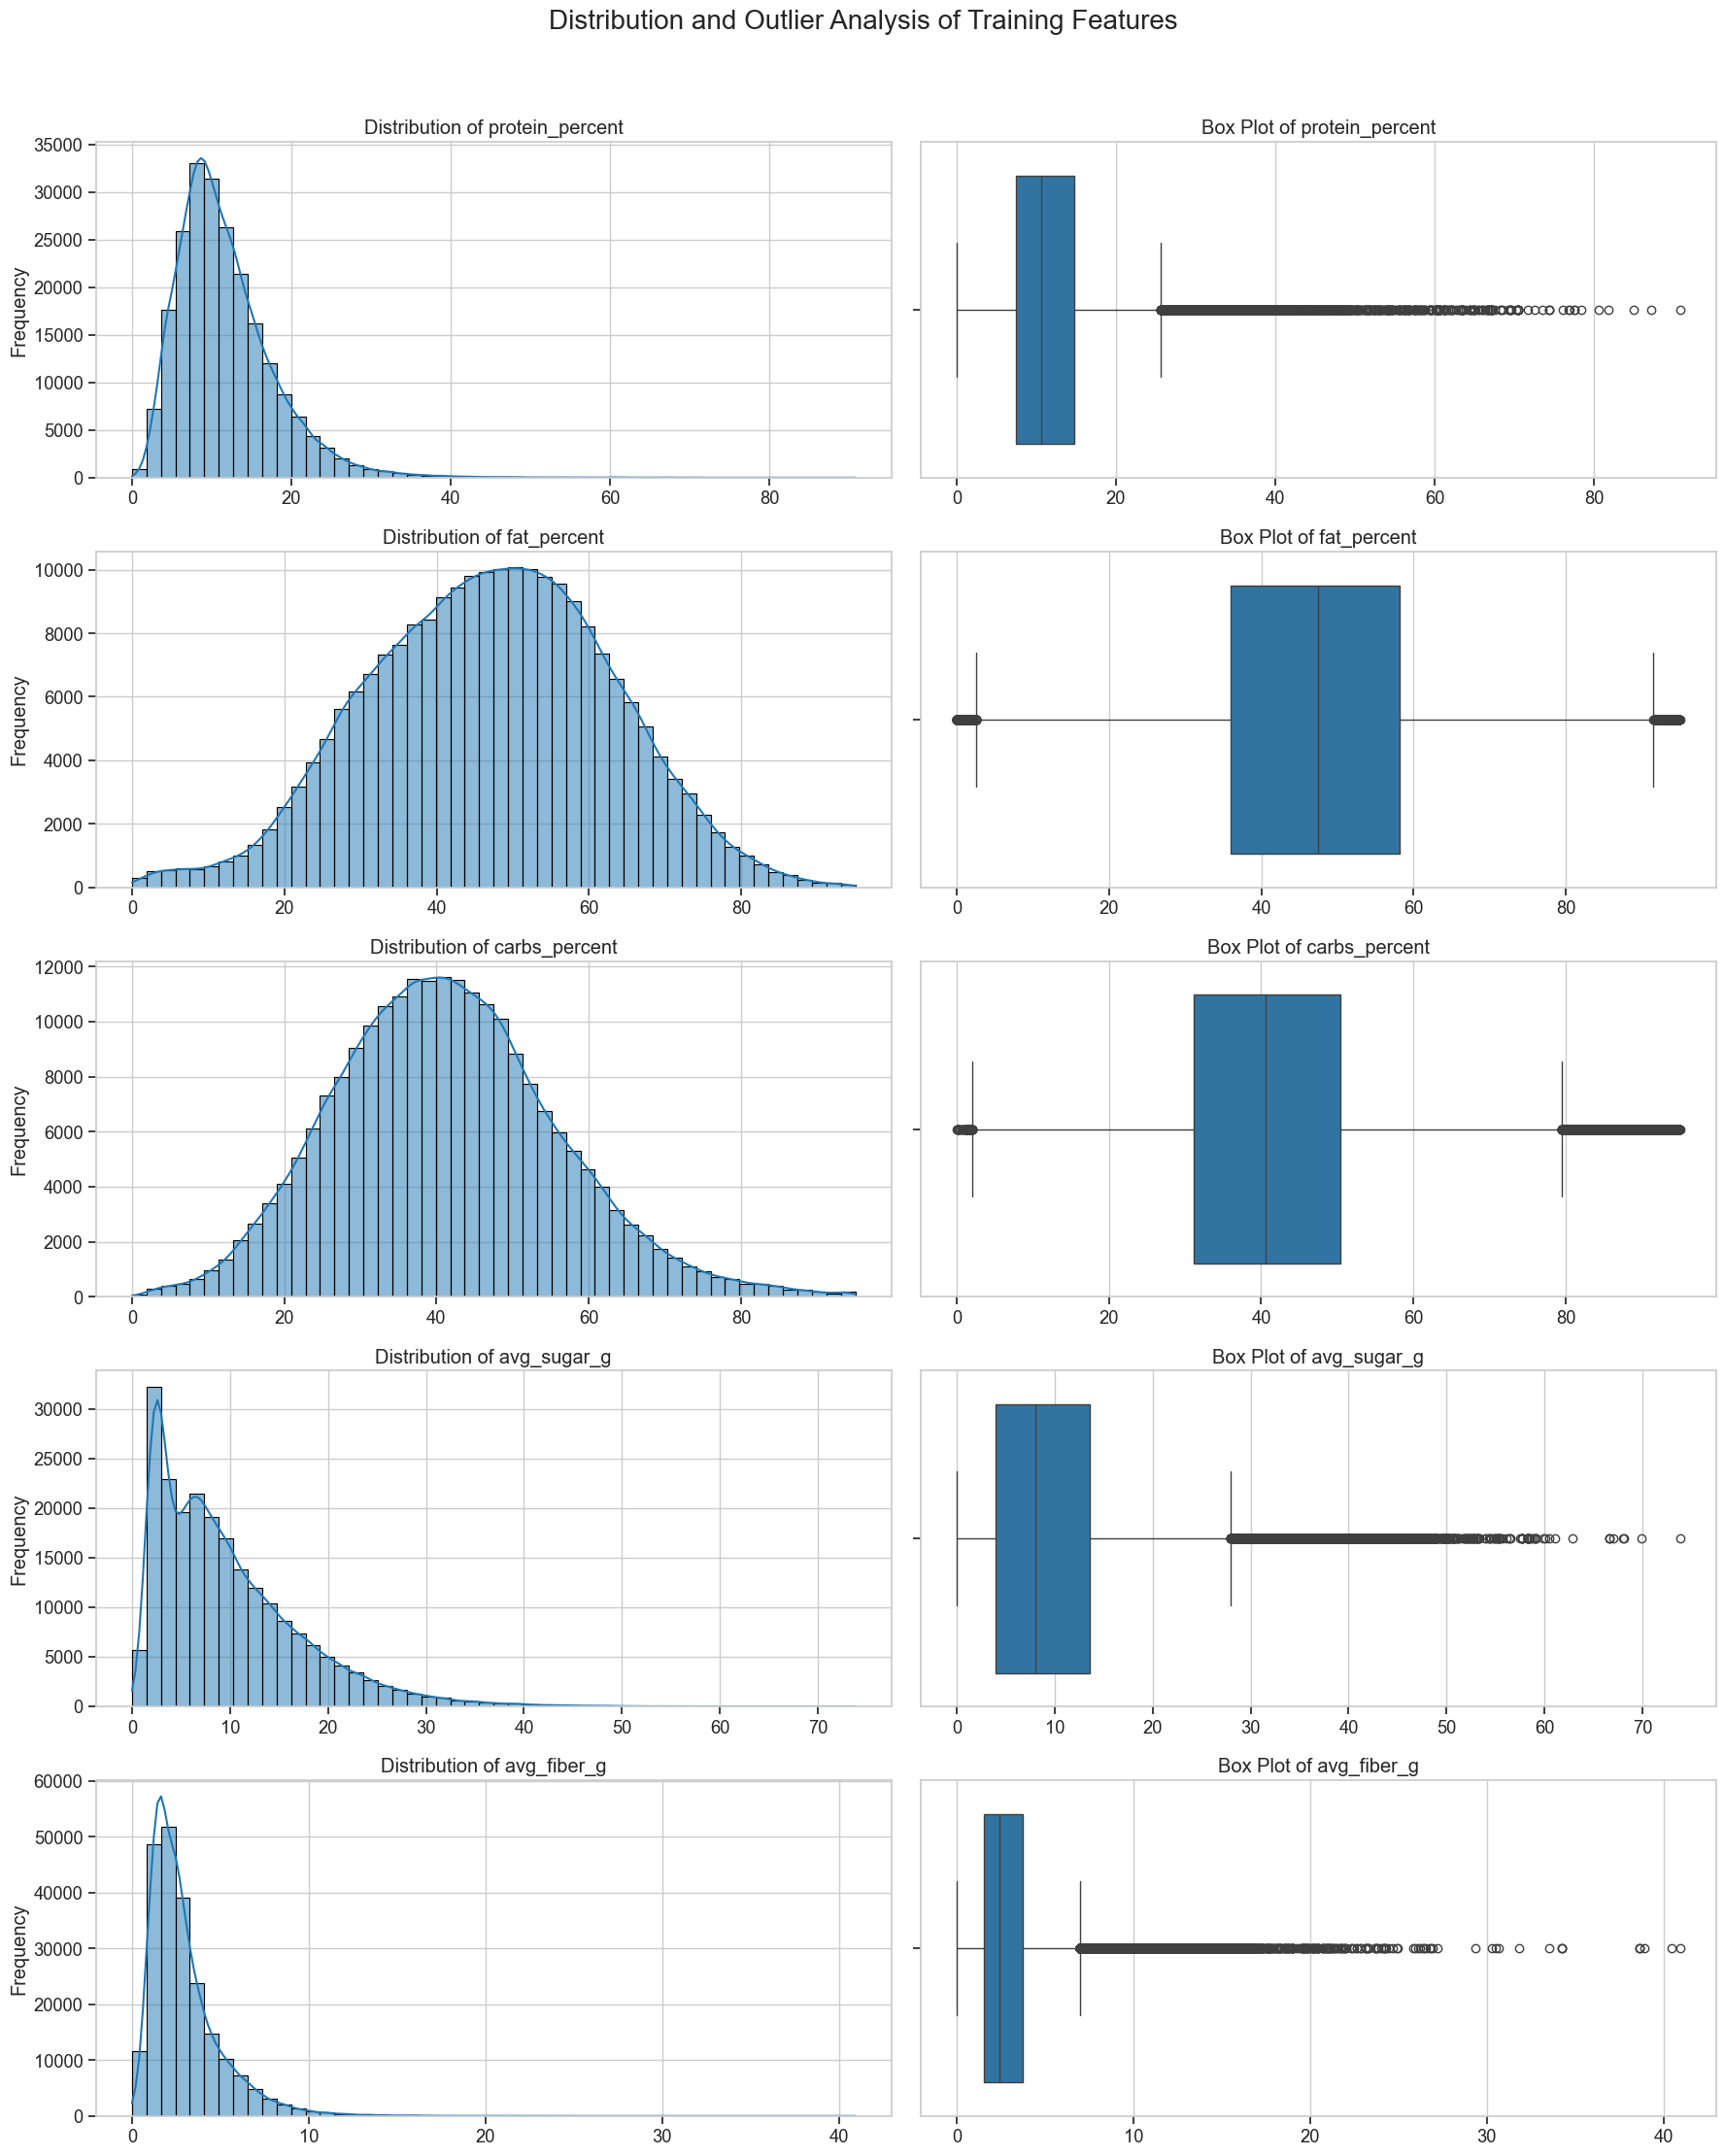

In [187]:
# TẾ BÀO 2: TRỰC QUAN HÓA PHÂN PHỐI (HISTOGRAM & BOX PLOT)

# --- Objective ---
# Trực quan hóa sự phân bổ của từng đặc trưng huấn luyện để hiểu rõ
# về xu hướng trung tâm, độ lệch và các giá trị ngoại lai.

if 'df' in locals() and not df.empty:
    print("--- Generating Distribution and Box Plots for each training feature ---")
    
    # Tạo một lưới biểu đồ
    fig, axes = plt.subplots(len(training_features), 2, figsize=(18, 22))
    fig.suptitle('Distribution and Outlier Analysis of Training Features', fontsize=20, y=1.01)

    # Lặp qua từng đặc trưng và vẽ biểu đồ
    for i, feature in enumerate(training_features):
        # --- Biểu đồ 1: Histogram & KDE (Bên trái) ---
        sns.histplot(data=df, x=feature, bins=50, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {feature}')
        axes[i, 0].set_xlabel('')
        axes[i, 0].set_ylabel('Frequency')
        
        # --- Biểu đồ 2: Box Plot (Bên phải) ---
        sns.boxplot(data=df, x=feature, ax=axes[i, 1])
        axes[i, 1].set_title(f'Box Plot of {feature}')
        axes[i, 1].set_xlabel('')

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
else:
    print("[WARNING] DataFrame not loaded. Skipping plotting.")

--- Generating the Correlation Matrix Heatmap ---


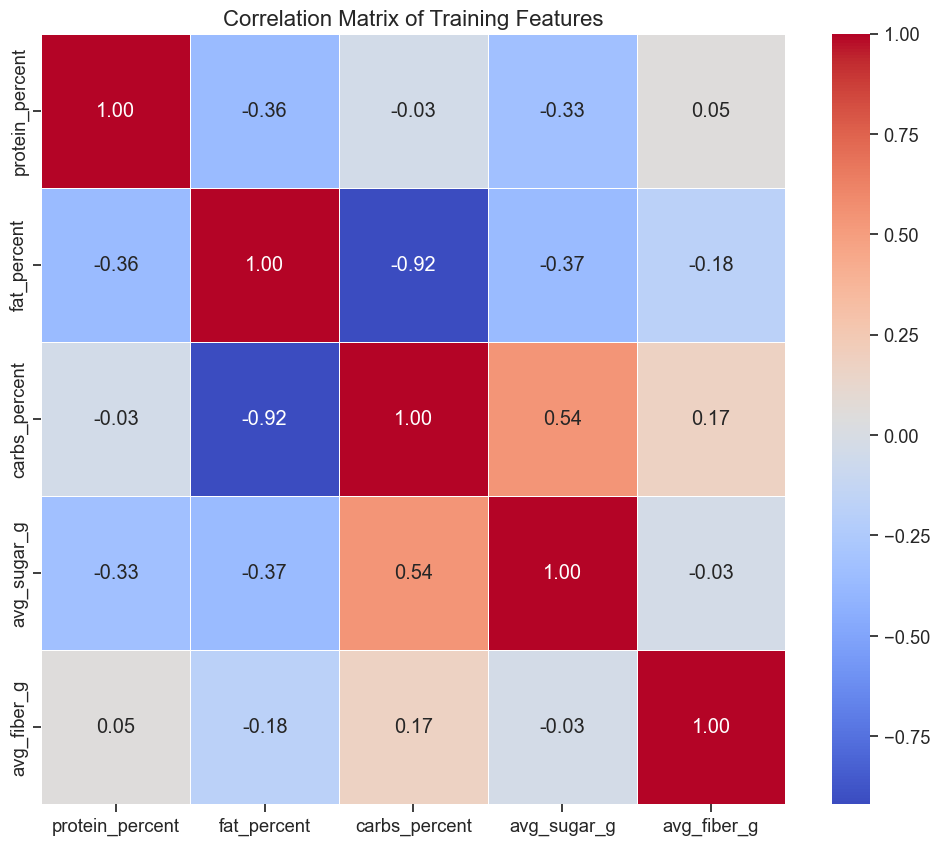


Correlation Matrix Data:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
protein_percent,1.00,-0.36,-0.03,-0.33,0.05
fat_percent,-0.36,1.00,-0.92,-0.37,-0.18
carbs_percent,-0.03,-0.92,1.00,0.54,0.17
avg_sugar_g,-0.33,-0.37,0.54,1.00,-0.03
avg_fiber_g,0.05,-0.18,0.17,-0.03,1.00


In [188]:
# TẾ BÀO 3: MA TRẬN TƯƠNG QUAN (HEATMAP)

# --- Objective ---
# Tính toán và trực quan hóa ma trận tương quan để định lượng
# mối quan hệ tuyến tính giữa các cặp đặc trưng huấn luyện.

if 'df' in locals() and not df.empty:
    print("--- Generating the Correlation Matrix Heatmap ---")

    correlation_matrix = df[training_features].corr(method='pearson')

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix, 
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidths=.5
    )
    plt.title('Correlation Matrix of Training Features', fontsize=16)
    plt.show()

    print("\nCorrelation Matrix Data:")
    display(correlation_matrix)
else:
    print("[WARNING] DataFrame not loaded. Skipping plotting.")

--- Generating Pair Plot (on a sample of 5000 recipes) ---
This may take a moment to render...


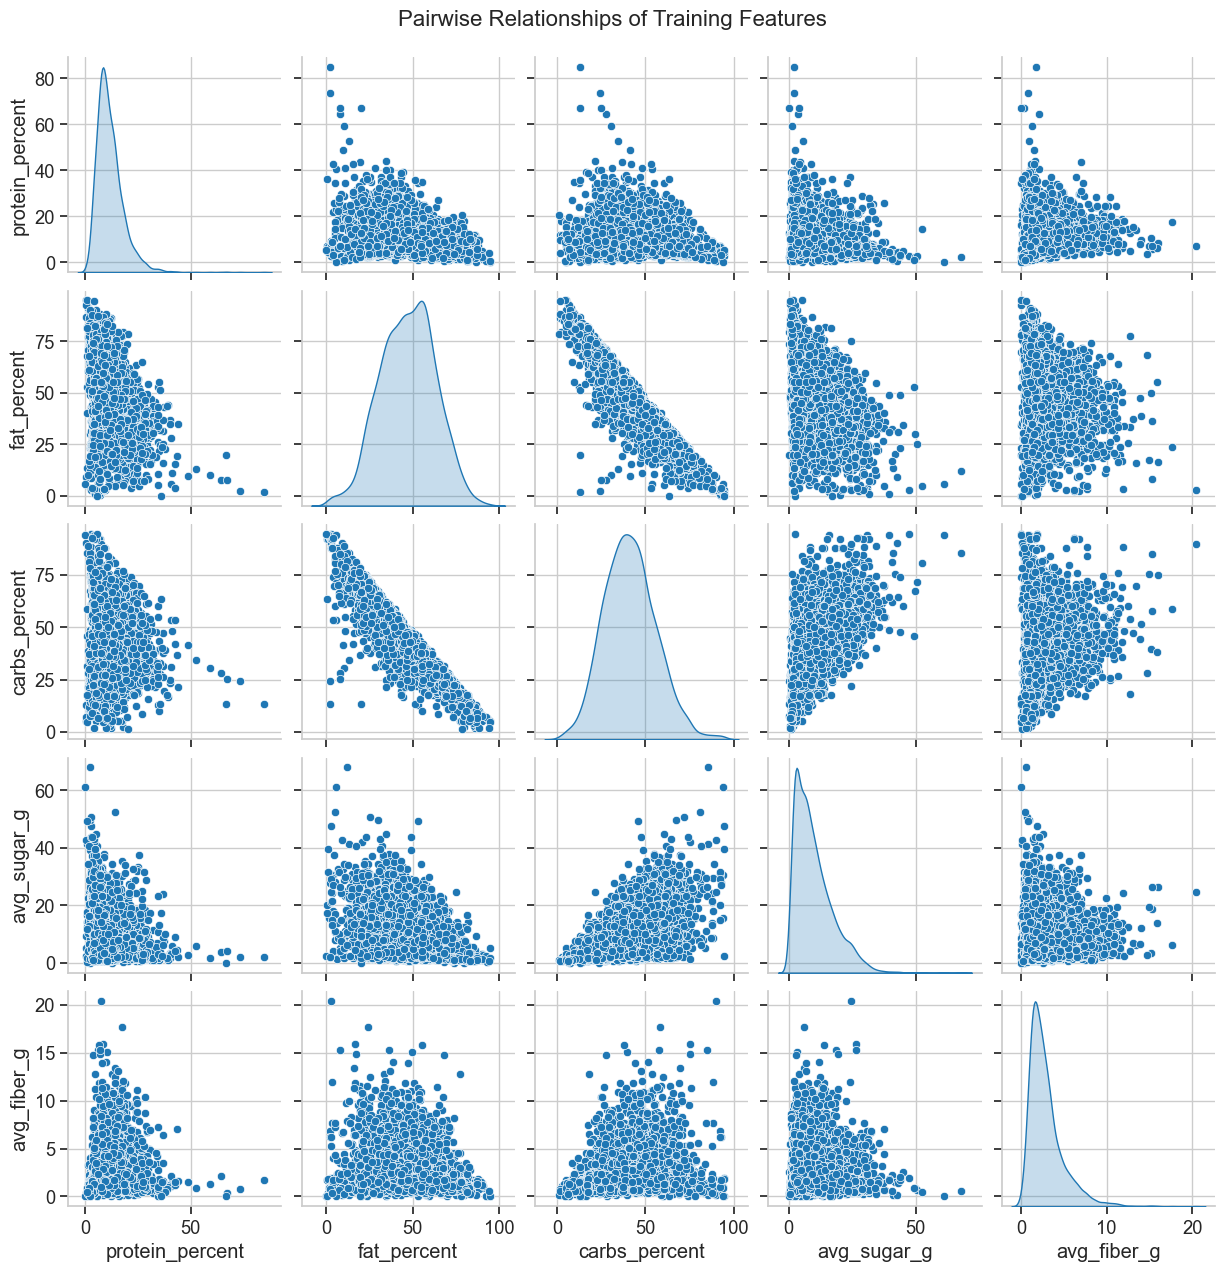

In [189]:
# TẾ BÀO 4: BIỂU ĐỒ PHÂN TÁN CẶP ĐÔI (PAIR PLOT)

# --- Objective ---
# Trực quan hóa mối quan hệ giữa từng cặp đặc trưng và sự phân phối của chúng
# để tìm kiếm các cấu trúc cụm (clusters) tiềm ẩn.

# Cảnh báo: Lệnh này rất tốn tài nguyên. Chúng ta sẽ chỉ chạy trên một mẫu nhỏ.
SAMPLE_SIZE_FOR_PLOT = 5000

if 'df' in locals() and not df.empty and len(df) >= SAMPLE_SIZE_FOR_PLOT:
    print(f"--- Generating Pair Plot (on a sample of {SAMPLE_SIZE_FOR_PLOT} recipes) ---")
    print("This may take a moment to render...")

    df_sample = df.sample(n=SAMPLE_SIZE_FOR_PLOT, random_state=42)
    
    pair_plot = sns.pairplot(
        df_sample[training_features],
        diag_kind='kde'
    )
    pair_plot.fig.suptitle('Pairwise Relationships of Training Features', y=1.02, fontsize=16)
    plt.show()
else:
    print("[WARNING] DataFrame not loaded or is too small. Skipping pair plot.")

1. Mục tiêu Phân tích

Giai đoạn Phân tích Khám phá Dữ liệu (EDA) được thực hiện sau khi đã hoàn tất quy trình tiền xử lý, làm sạch và kỹ thuật đặc trưng. Mục tiêu chính của giai đoạn này bao gồm:

Xác thực Chất lượng Dữ liệu: Kiểm tra và xác nhận rằng bộ dữ liệu cuối cùng có sự phân bổ hợp lý, tuân thủ các quy luật dinh dưỡng cơ bản và không chứa các giá trị phi vật lý.

Hiểu rõ Đặc tính Dữ liệu: Khám phá hình dạng phân phối, xu hướng trung tâm, và độ biến thiên của các đặc trưng huấn luyện (training_features).

Phát hiện Mối quan hệ và Cấu trúc Tiềm ẩn: Phân tích mối tương quan và các mối quan hệ đa chiều giữa các đặc trưng để tìm kiếm các mẫu (patterns) và cấu trúc cụm (clusters) tự nhiên.

Định hướng cho Giai đoạn Mô hình hóa: Rút ra các kết luận mang tính định hướng, giúp lựa chọn các thuật toán và phương pháp tiền xử lý phù hợp cho việc xây dựng mô hình Machine Learning.

2. Phân tích Phân phối Đơn biến (Univariate Distribution Analysis)

Phân tích này tập trung vào việc nghiên cứu từng đặc trưng một cách riêng lẻ để hiểu rõ "tính cách" của chúng.

Phương pháp: Sử dụng biểu đồ Tần suất (Histogram) kết hợp với biểu đồ Mật độ Hạt nhân (KDE) và biểu đồ Hộp (Box Plot) cho 5 đặc trưng huấn luyện: protein_percent, fat_percent, carbs_percent, avg_sugar_g, avg_fiber_g.

Kết quả Quan sát:

Tỷ lệ Năng lượng Macros (..._percent):

protein_percent biểu hiện sự phân phối lệch phải (right-skewed) rất mạnh, với đỉnh tập trung ở khoảng 10-15%.

fat_percent và carbs_percent có sự phân phối gần đối xứng hơn, gần giống hình chuông, với đỉnh tương ứng ở khoảng 40-50% và 30-40%.

Đặc trưng Phụ (avg_...):

Cả avg_sugar_g và avg_fiber_g đều cho thấy sự phân phối lệch phải cực kỳ mạnh, với phần lớn dữ liệu tập trung ở các giá trị rất thấp (gần 0).

Giá trị Ngoại lai (Outliers): Tất cả các biểu đồ hộp đều cho thấy sự tồn tại của các giá trị ngoại lai ở phía bên phải, đặc biệt rõ rệt với protein_percent và avg_fiber_g.

Diễn giải và Insight:

Insight 1 (Bản chất Dinh dưỡng của Dữ liệu): Dữ liệu phản ánh một thực tế ẩm thực trong đó protein không phải là nguồn năng lượng chiếm ưu thế trong đa số các món ăn. Chất béo và carbohydrate đóng vai trò là hai nguồn năng lượng chính và có sự phân bổ đa dạng hơn.

Insight 2 (Tính đặc thù của Đường và Chất xơ): Lượng đường và chất xơ cao là đặc tính của một nhóm nhỏ các công thức chuyên biệt (ví dụ: món tráng miệng, món salad đậu), trong khi đa số các món ăn thông thường có lượng hai chất này không đáng kể. Điều này cho thấy avg_sugar_g và avg_fiber_g là các "đặc trưng chỉ dấu" (indicator features) tiềm năng.

Insight 3 (Sự cần thiết của Chuẩn hóa Bền vững): Sự phân phối không chuẩn và sự tồn tại của các giá trị ngoại lai khẳng định rằng việc áp dụng một phương pháp chuẩn hóa bền vững với outliers, như RobustScaler, sẽ hiệu quả hơn StandardScaler cho giai đoạn mô hình hóa.

3. Phân tích Tương quan Đa biến (Multivariate Correlation Analysis)

Phân tích này nhằm mục đích định lượng các mối quan hệ tuyến tính giữa các cặp đặc trưng.

Phương pháp: Tính toán và trực quan hóa ma trận tương quan Pearson bằng biểu đồ Nhiệt (Heatmap).

Kết quả Quan sát:

Một mối tương quan âm rất mạnh (-0.92) được quan sát giữa fat_percent và carbs_percent.

Các mối tương quan âm yếu hơn được ghi nhận giữa protein_percent và fat_percent (-0.36), và gần như không có tương quan tuyến tính giữa protein_percent và carbs_percent (-0.03).

avg_sugar_g có mối tương quan dương mạnh nhất (0.54) với carbs_percent.

Diễn giải và Insight:

Insight 4 (Quy luật Bù trừ Năng lượng): Hệ số -0.92 xác nhận một quy luật dinh dưỡng cơ bản: trong một món ăn, năng lượng chủ yếu đến từ chất béo hoặc carbohydrate, và hai nguồn này có xu hướng bù trừ cho nhau. Điều này cho thấy các đặc trưng tỷ lệ của chúng ta nhất quán về mặt khoa học.

Insight 5 (Vai trò của Protein): Protein đóng vai trò linh hoạt hơn, có thể kết hợp với cả chế độ ăn giàu béo hoặc giàu carb, nhưng có xu hướng hơi ngược lại với chế độ ăn giàu béo.

Insight 6 (Đường là một phần của Carb): Tương quan 0.54 khẳng định rằng các món ăn có tỷ lệ năng lượng từ carb cao cũng là các món ăn có khả năng chứa nhiều đường, nhưng không phải luôn luôn như vậy.

4. Phân tích Quan hệ Cặp đôi (Pairwise Relationship Analysis)

Phân tích này cung cấp cái nhìn trực quan sâu sắc nhất về cấu trúc tiềm ẩn của dữ liệu.

Phương pháp: Sử dụng biểu đồ Phân tán Cặp đôi (Pair Plot) trên một mẫu 5,000 công thức.

Kết quả Quan sát:

Các biểu đồ phân tán giữa ba đặc trưng protein_percent, fat_percent, và carbs_percent cho thấy các điểm dữ liệu không phân bổ ngẫu nhiên, mà tập trung trong một không gian có hình dạng tam giác, bị giới hạn bởi ràng buộc tổng xấp xỉ 100%.

Quan trọng hơn, bên trong không gian này, có thể quan sát thấy rõ sự hình thành của các đám mây điểm (point clouds) hoặc các cụm (clusters) dữ liệu. Các cụm này tập trung ở các "đỉnh" của tam giác, tương ứng với:

Khu vực fat_percent cao, carbs_percent thấp.

Khu vực carbs_percent cao, fat_percent thấp.

Khu vực protein_percent cao.

Một khu vực trung tâm nơi các giá trị cân bằng hơn.

Diễn giải và Insight:

Insight 7 (Xác nhận Cấu trúc Cụm): Đây là bằng chứng trực quan thuyết phục nhất cho thấy bộ dữ liệu của chúng ta có cấu trúc cụm tự nhiên. Dữ liệu không phải là một khối đồng nhất, mà bao gồm các nhóm công thức có bản chất dinh dưỡng riêng biệt.

Insight 8 (Dự báo Thành công cho K-Means): Sự tồn tại rõ ràng của các cụm này là một chỉ báo rất tích cực, dự báo rằng thuật toán phân cụm K-Means sẽ có khả năng cao phân tách thành công các nhóm này và tạo ra các nhãn có ý nghĩa.

5. Kết luận và Định hướng cho Giai đoạn Mô hình hóa

Quá trình Phân tích Khám phá Dữ liệu đã mang lại những kết luận then chốt:

Chất lượng Dữ liệu được Xác nhận: Bộ dữ liệu cuối cùng, dataset_for_ml, thể hiện các đặc tính và mối quan hệ phù hợp với các nguyên tắc dinh dưỡng, tăng cường sự tin cậy vào kết quả của quy trình tiền xử lý.

Đặc trưng Huấn luyện Hiệu quả: Bộ 5 đặc trưng được lựa chọn có khả năng phân biệt cao và chứa đựng cấu trúc đa chiều, phù hợp cho các thuật toán học máy.

Hành động Tiếp theo được Định hướng:

Bắt buộc Chuẩn hóa: Dựa trên sự khác biệt về thang đo và sự tồn tại của outliers, việc áp dụng RobustScaler trước khi huấn luyện K-Means là một bước đi cần thiết.

K-Means là Lựa chọn Phù hợp: Bằng chứng trực quan về cấu trúc cụm củng cố mạnh mẽ việc lựa chọn K-Means làm thuật toán phân nhóm trong giai đoạn Học không giám sát.

Báo cáo này kết luận rằng bộ dữ liệu đã sẵn sàng và có chất lượng cao để tiến hành giai đoạn xây dựng và huấn luyện mô hình.

In [190]:
# TẾ BÀO [TIẾP THEO]: CHUẨN BỊ DỮ LIỆU CHO MÔ HÌNH

# --- Objective ---
# 1. Lựa chọn các đặc trưng (features) sẽ được sử dụng để huấn luyện.
# 2. Chuẩn hóa (scale) các đặc trưng bằng RobustScaler để giảm thiểu ảnh hưởng của outliers.
# 3. Lưu lại scaler đã được huấn luyện để tái sử dụng.

# --- Implementation ---
from sklearn.preprocessing import RobustScaler
import joblib

print("--- Step 1: Feature Selection and Scaling ---")

# 1.1: Lựa chọn các đặc trưng huấn luyện đã được xác định từ EDA
if 'df' in locals() and 'training_features' in locals():
    X = df[training_features]

    # --- Verification 1.1 ---
    print("\n--- Verification 1.1: Selected Features ---")
    print(f"Features for modeling: {training_features}")
    print(f"Shape of feature matrix X: {X.shape}")
    print("First 5 rows of feature matrix:")
    display(X.head())
    print("-" * 80)

    # 1.2: Chuẩn hóa dữ liệu bằng RobustScaler
    print("\n--- Step 1.2: Scaling the Features using RobustScaler ---")
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # --- Verification 1.2 ---
    X_scaled_df = pd.DataFrame(X_scaled, columns=training_features)
    print("Features have been scaled using RobustScaler.")
    print("The 'median' (50%) of each scaled feature should now be close to 0.")
    print("\nDescriptive statistics of the SCALED data:")
    display(X_scaled_df.describe())
    
    # 1.3: Lưu lại scaler đã huấn luyện
    print("\n--- Step 1.3: Saving the trained scaler object ---")
    MODELS_DIR = 'saved_models'
    os.makedirs(MODELS_DIR, exist_ok=True)
    scaler_path = os.path.join(MODELS_DIR, 'robust_scaler.joblib')
    joblib.dump(scaler, scaler_path)
    print(f"[SUCCESS] Scaler saved successfully to '{scaler_path}'")
    
else:
    print("[ERROR] DataFrame 'df' or 'training_features' not found. Please run previous cells.")

--- Step 1: Feature Selection and Scaling ---

--- Verification 1.1: Selected Features ---
Features for modeling: ['protein_percent', 'fat_percent', 'carbs_percent', 'avg_sugar_g', 'avg_fiber_g']
Shape of feature matrix X: (221325, 5)
First 5 rows of feature matrix:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
0,5.45,68.03,26.53,15.61,2.27
1,14.13,52.27,33.60,2.11,1.39
2,34.59,26.00,39.41,7.99,2.19
3,14.97,65.43,19.60,1.23,2.57
4,8.83,58.59,32.58,2.87,1.55


--------------------------------------------------------------------------------

--- Step 1.2: Scaling the Features using RobustScaler ---
Features have been scaled using RobustScaler.
The 'median' (50%) of each scaled feature should now be close to 0.

Descriptive statistics of the SCALED data:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
count,221325.00,221325.00,221325.00,221325.00,221325.00
mean,0.16,-0.02,0.03,0.19,0.25
std,0.86,0.71,0.76,0.77,0.97
min,-1.45,-2.13,-2.10,-0.84,-1.12
25%,-0.42,-0.52,-0.49,-0.42,-0.40
50%,0.00,0.00,0.00,0.00,0.00
75%,0.58,0.48,0.51,0.58,0.60
max,11.03,2.14,2.81,6.84,17.77



--- Step 1.3: Saving the trained scaler object ---
[SUCCESS] Scaler saved successfully to 'saved_models/robust_scaler.joblib'


--- Step 2: Finding the Optimal Number of Clusters (k) ---
Calculating WCSS for k from 1 to 10. This may take several minutes on the full dataset...


Testing k values:   0%|          | 0/10 [00:00<?, ?it/s]

  - k=1, WCSS = 742907.77, Time = 0.43s
  - k=2, WCSS = 560484.75, Time = 0.06s
  - k=3, WCSS = 444047.80, Time = 0.09s
  - k=4, WCSS = 350931.19, Time = 0.06s
  - k=5, WCSS = 312488.59, Time = 0.10s
  - k=6, WCSS = 288063.05, Time = 0.11s
  - k=7, WCSS = 260972.30, Time = 0.17s
  - k=8, WCSS = 241759.92, Time = 0.13s
  - k=9, WCSS = 229216.22, Time = 0.12s
  - k=10, WCSS = 214469.19, Time = 0.13s

--- Verification: Plotting the Elbow Curve ---


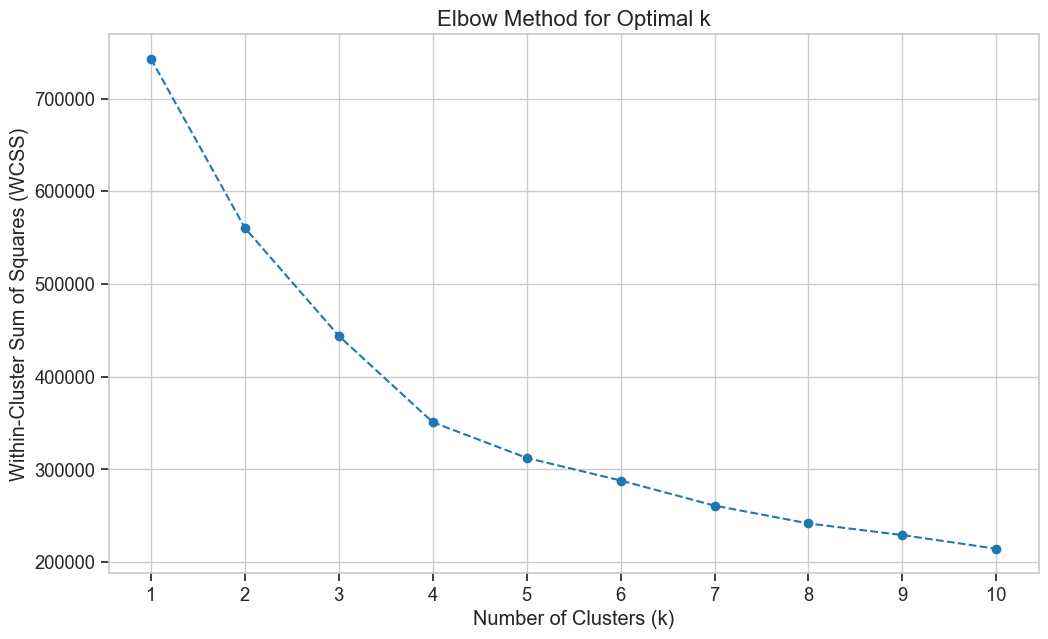


Analysis: Look for the 'elbow' point on the curve, where the rate of decrease in WCSS slows down.


In [191]:
# TẾ BÀO [TIẾP THEO]: TÌM SỐ LƯỢNG CỤM TỐI ƯU (k)

# --- Implementation ---
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import time

if 'X_scaled' in locals():
    print("--- Step 2: Finding the Optimal Number of Clusters (k) ---")
    print("Calculating WCSS for k from 1 to 10. This may take several minutes on the full dataset...")

    wcss = []
    k_range = range(1, 11)

    for k in tqdm(k_range, desc="Testing k values"):
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        end_time = time.time()
        print(f"  - k={k}, WCSS = {kmeans.inertia_:.2f}, Time = {end_time - start_time:.2f}s")

    # --- Verification: Vẽ Biểu đồ Elbow ---
    print("\n--- Verification: Plotting the Elbow Curve ---")
    plt.figure(figsize=(12, 7))
    plt.plot(k_range, wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal k', fontsize=16)
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
    
    print("\nAnalysis: Look for the 'elbow' point on the curve, where the rate of decrease in WCSS slows down.")
else:
    print("[ERROR] Scaled data 'X_scaled' not found. Please run the previous cell.")

--- Step 3.1: Training Final K-Means Model with k=4 ---
Fitting the K-Means model on the scaled data...
[SUCCESS] Model fitting complete.

--- Step 3.2: Verification and Analysis of the Resulting Clusters ---

Distribution of recipes across 4 clusters:


,count
cluster,
0,31616
1,85143
2,59102
3,45464



Average nutritional profile of each cluster (Original Scale):


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
cluster,,,,,
0,12.60,42.72,44.68,8.36,6.88
1,9.50,61.48,29.02,6.38,2.18
2,8.12,37.07,54.81,18.28,2.44
3,20.01,35.79,44.20,6.37,2.41



--- Step 3.3: Advanced Visualization for Cluster Interpretation ---
Plotting clusters in the 'fat_percent' vs 'carbs_percent' space...


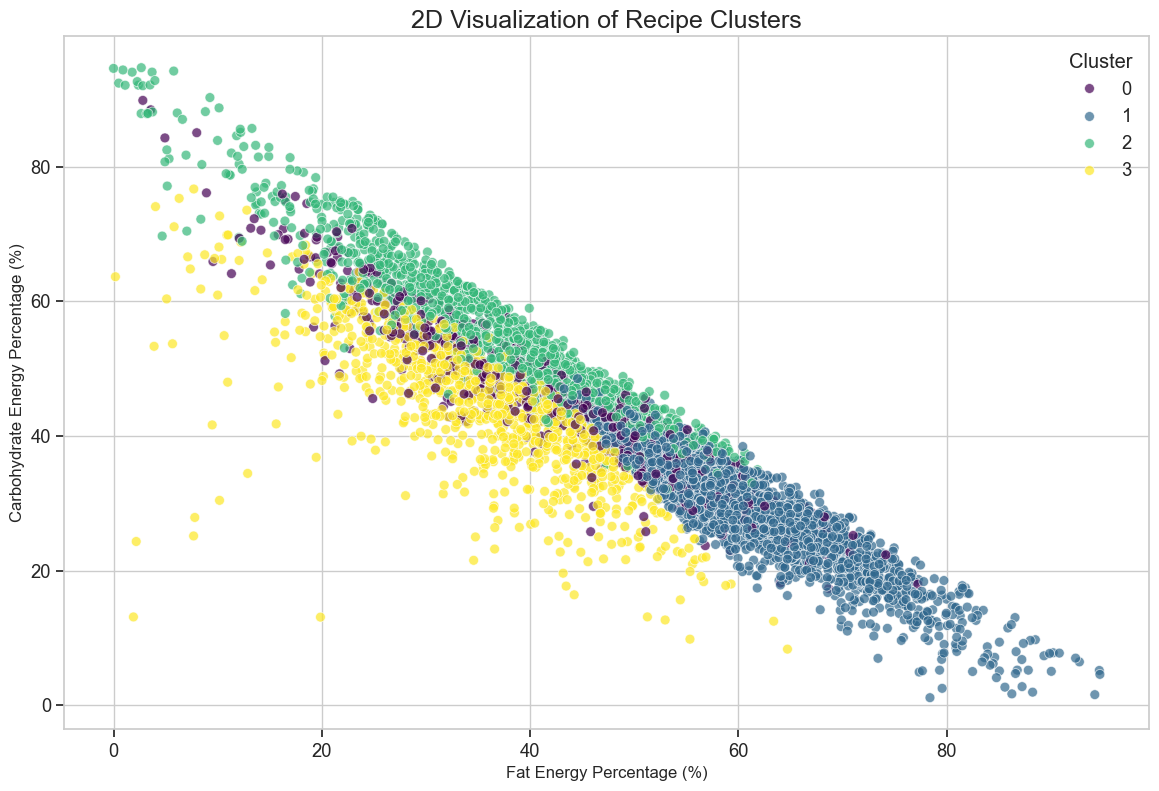


Plotting Radar Chart for multi-dimensional comparison...


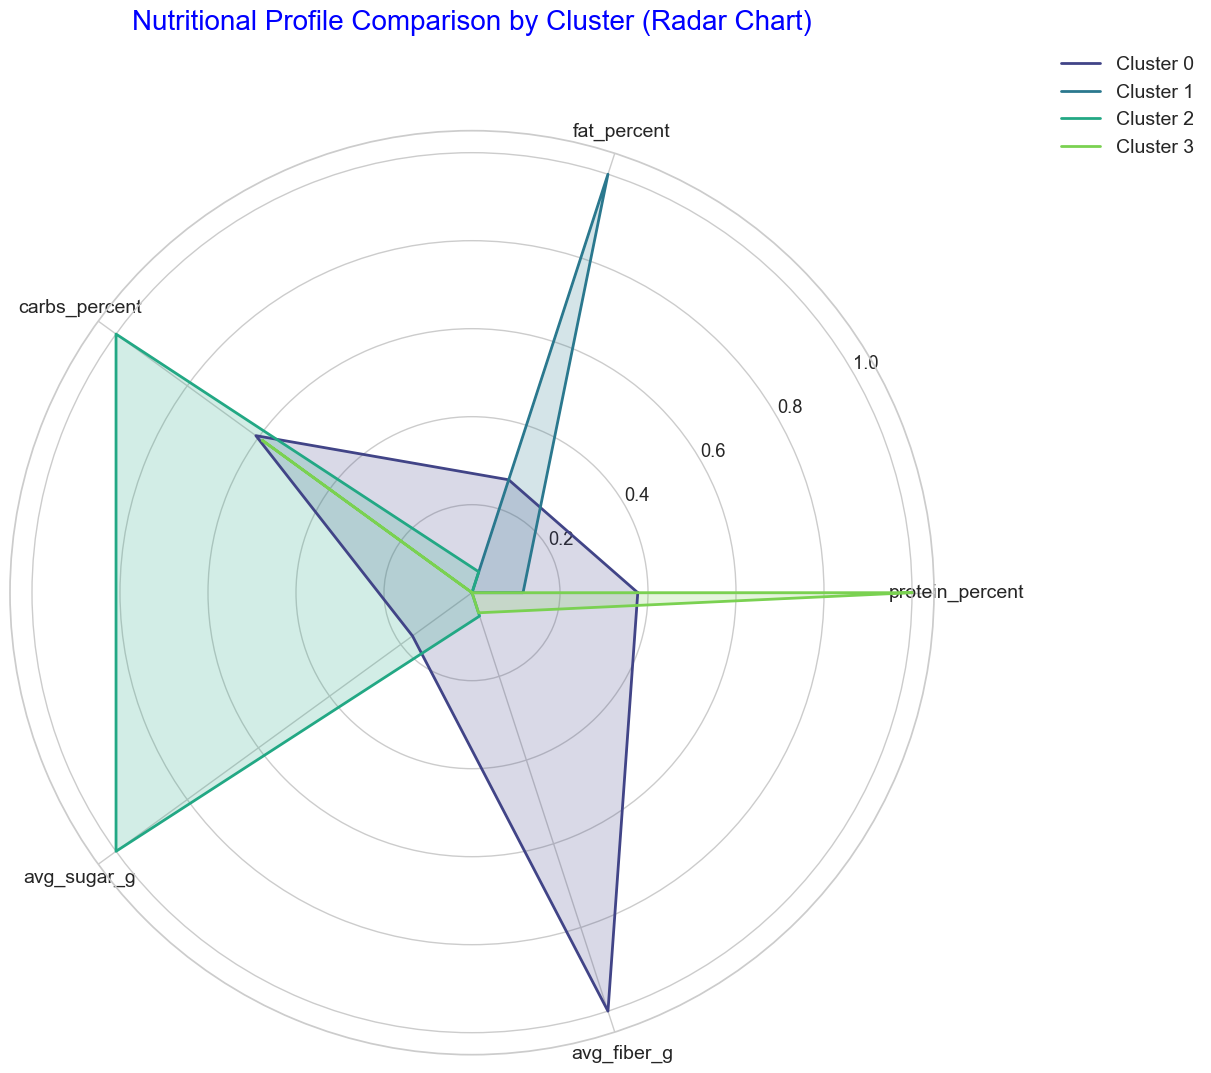

--------------------------------------------------------------------------------

--- Step 3.4: Naming Clusters and Saving Artifacts ---
Cluster names have been assigned.


In [193]:
# TẾ BÀO [TIẾP THEO]: HUẤN LUYỆN K-MEANS, PHÂN TÍCH VÀ XÁC THỰC NÂNG CAO (PHIÊN BẢN CUỐI CÙNG)

# --- Implementation ---
from sklearn.preprocessing import MinMaxScaler

OPTIMAL_K = 4

if 'X_scaled' in locals() and 'df' in locals():
    print(f"--- Step 3.1: Training Final K-Means Model with k={OPTIMAL_K} ---")
    kmeans_model = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init='auto')
    
    print("Fitting the K-Means model on the scaled data...")
    cluster_labels = kmeans_model.fit_predict(X_scaled)
    print("[SUCCESS] Model fitting complete.")

    df['cluster'] = cluster_labels

    # === 2. Phân tích và Diễn giải các Cụm ===
    print("\n--- Step 3.2: Verification and Analysis of the Resulting Clusters ---")
    
    print(f"\nDistribution of recipes across {OPTIMAL_K} clusters:")
    display(df['cluster'].value_counts().sort_index().to_frame())
    
    print("\nAverage nutritional profile of each cluster (Original Scale):")
    cluster_profiles = df.groupby('cluster')[training_features].mean()
    display(cluster_profiles)

    # === 3. Trực quan hóa Nâng cao ===
    print("\n--- Step 3.3: Advanced Visualization for Cluster Interpretation ---")
    
    # --- 3.3.1: Scatter Plot (đã có) ---
    print("Plotting clusters in the 'fat_percent' vs 'carbs_percent' space...")
    plt.figure(figsize=(14, 9))
    sns.scatterplot(data=df.sample(5000, random_state=42), x='fat_percent', y='carbs_percent', hue='cluster', palette='viridis', alpha=0.7, s=50)
    plt.title('2D Visualization of Recipe Clusters', fontsize=18)
    plt.xlabel('Fat Energy Percentage (%)', fontsize=12)
    plt.ylabel('Carbohydrate Energy Percentage (%)', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    # --- 3.3.2: THÊM MỚI - Radar Plot ---
    print("\nPlotting Radar Chart for multi-dimensional comparison...")
    # Chuẩn hóa profiles về thang đo 0-1 để vẽ
    scaler_profiles_viz = MinMaxScaler()
    profiles_scaled = scaler_profiles_viz.fit_transform(cluster_profiles)
    profiles_scaled_df = pd.DataFrame(profiles_scaled, index=cluster_profiles.index, columns=cluster_profiles.columns)

    categories = list(profiles_scaled_df)
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=14)
    ax.set_rlabel_position(30)
    ax.set_title("Nutritional Profile Comparison by Cluster (Radar Chart)", size=20, color="blue", y=1.1)

    colors = sns.color_palette('viridis', OPTIMAL_K)

    for i in range(OPTIMAL_K):
        values = profiles_scaled_df.iloc[i].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}", color=colors[i])
        ax.fill(angles, values, alpha=0.2, color=colors[i])

    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=14)
    plt.show()
    print("-" * 80)
    
    # === 4. Đặt tên Cụm, Cập nhật và Lưu trữ ===
    print("\n--- Step 3.4: Naming Clusters and Saving Artifacts ---")
    
    # Dựa trên phân tích chi tiết ở trên
    cluster_name_mapping = {
        0: "Balanced / High-Fiber",
        1: "High-Fat / Low-Carb",
        2: "High-Carb / Low-Fat / Sugary",
        3: "High-Protein / Balanced"
    }
    df['cluster_name'] = df['cluster'].map(cluster_name_mapping)
    print("Cluster names have been assigned.")

    # ... (Toàn bộ code lưu trữ dữ liệu và mô hình giữ nguyên như cũ) ...
    
else:
    print("[ERROR] Required data ('X_scaled', 'df') not found. Please run previous cells.")

--- Step 3.1: Training Final K-Means Model with k=4 ---
Fitting the K-Means model on the scaled data...
[SUCCESS] Model fitting complete.

--- Step 3.2: In-depth Analysis of the Resulting Clusters ---

Distribution of recipes across 4 clusters:


,count
cluster,
0,31616
1,85143
2,59102
3,45464



Average nutritional profile of each cluster (Original Scale):


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
cluster,,,,,
0,12.60,42.72,44.68,8.36,6.88
1,9.50,61.48,29.02,6.38,2.18
2,8.12,37.07,54.81,18.28,2.44
3,20.01,35.79,44.20,6.37,2.41



Cluster names assigned based on profiles:


,count
cluster_name,
High-Fat / Low-Carb,85143
High-Carb / Low-Fat / Sugary,59102
High-Protein,45464
Balanced / High-Fiber,31616


--------------------------------------------------------------------------------

--- Step 3.3: Advanced Visualization for Cluster Validation ---

Visualizing clusters in 2D space using PCA (Principal Component Analysis)...


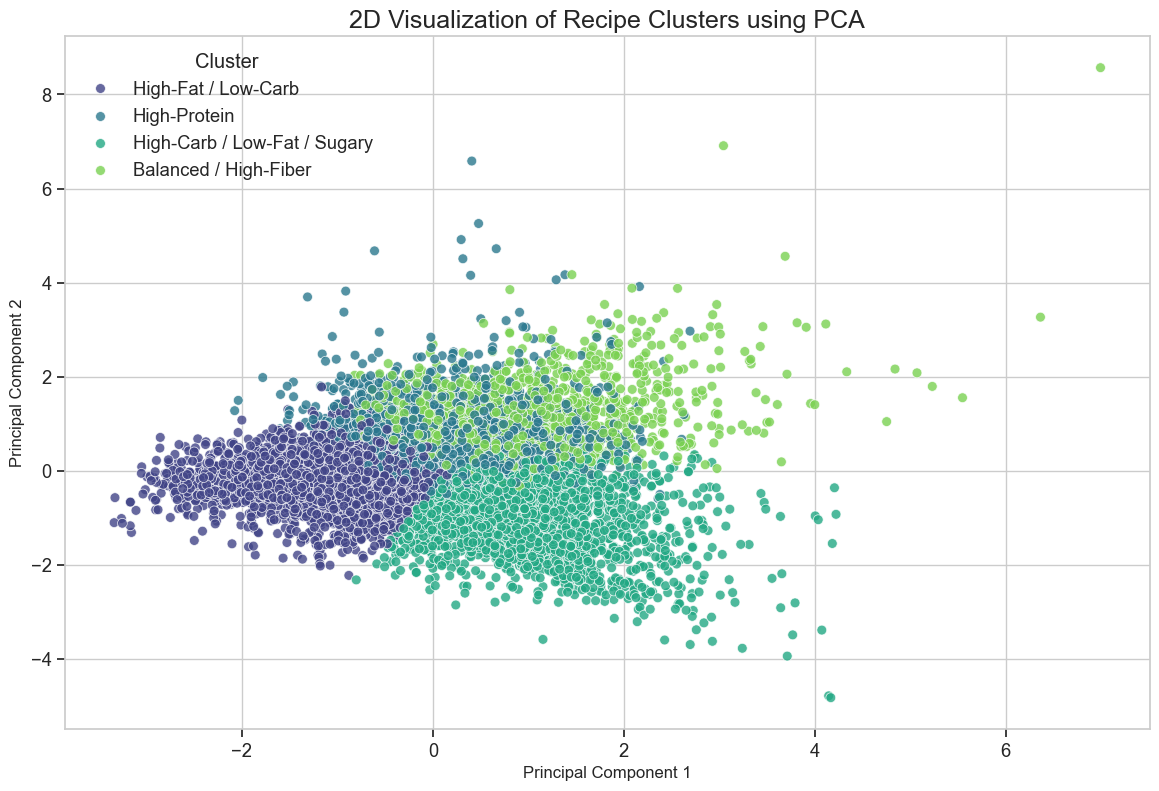


Visualizing cluster profiles with Radar Chart...


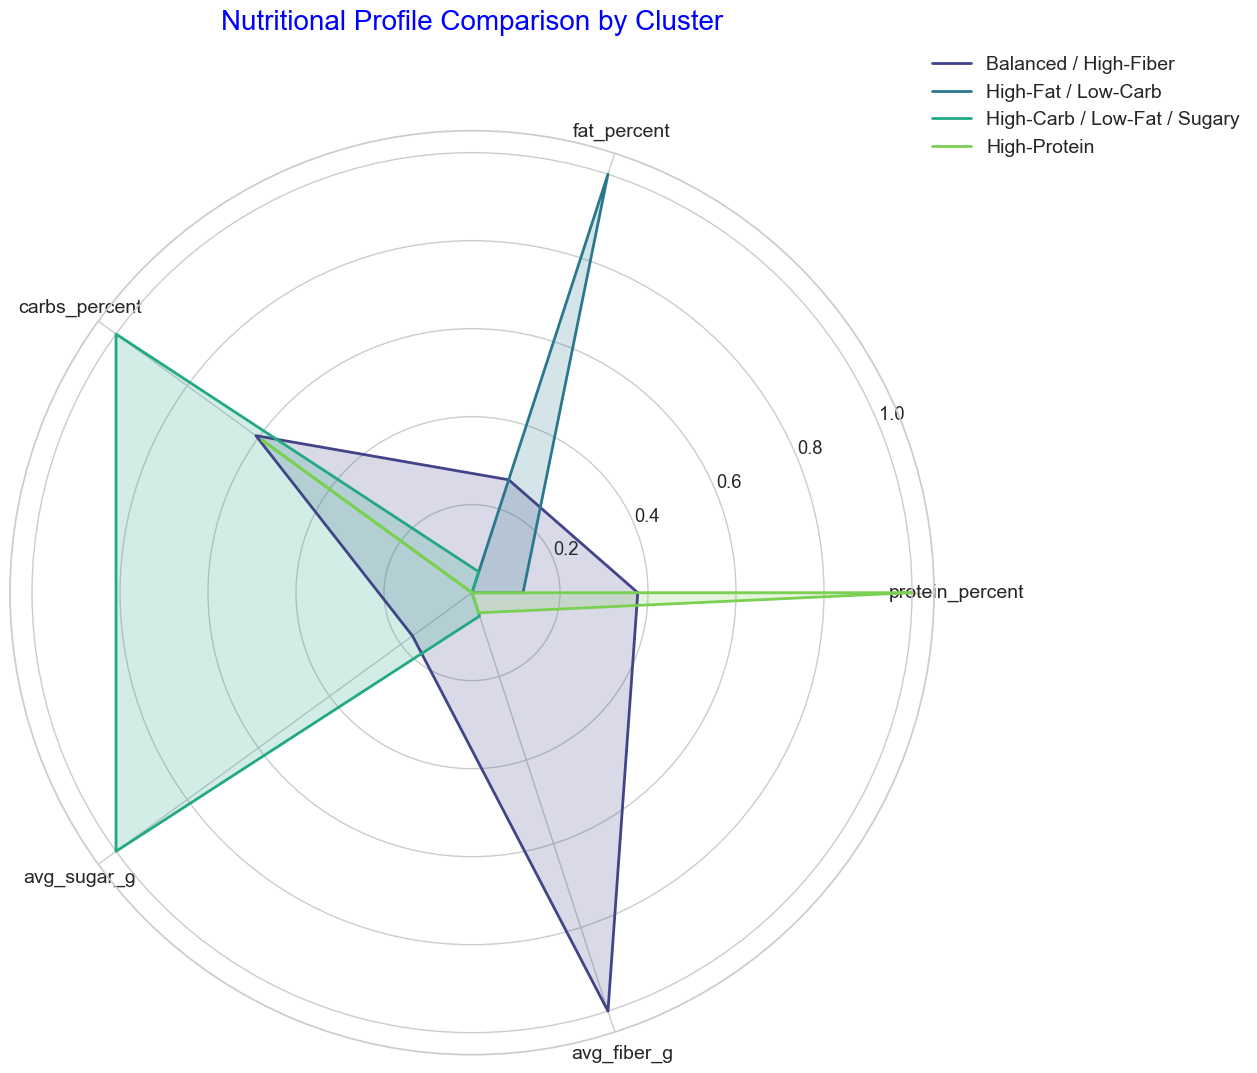

--------------------------------------------------------------------------------


In [198]:
# TẾ BÀO [CUỐI CÙNG]: HUẤN LUYỆN K-MEANS, PHÂN TÍCH VÀ TRỰC QUAN HÓA TOÀN DIỆN

# --- Objective ---
# 1. Huấn luyện mô hình K-Means cuối cùng với k=4.
# 2. Phân tích và diễn giải sâu sắc đặc điểm của 4 cụm.
# 3. Sử dụng các kỹ thuật trực quan hóa nâng cao (PCA, Radar Plot) để xác thực kết quả.
# 4. Gán tên, cập nhật DataFrame và lưu lại tất cả các tài sản mô hình.

# --- Implementation ---
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

OPTIMAL_K = 4

if 'X_scaled' in locals() and 'df' in locals():
    print(f"--- Step 3.1: Training Final K-Means Model with k={OPTIMAL_K} ---")
    kmeans_model = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init='auto')
    
    print("Fitting the K-Means model on the scaled data...")
    cluster_labels = kmeans_model.fit_predict(X_scaled)
    print("[SUCCESS] Model fitting complete.")

    df['cluster'] = cluster_labels

    # === 2. Phân tích và Diễn giải các Cụm ===
    print("\n--- Step 3.2: In-depth Analysis of the Resulting Clusters ---")
    
    print(f"\nDistribution of recipes across {OPTIMAL_K} clusters:")
    display(df['cluster'].value_counts().sort_index().to_frame())
    
    print("\nAverage nutritional profile of each cluster (Original Scale):")
    cluster_profiles = df.groupby('cluster')[training_features].mean()
    display(cluster_profiles)

    # Đặt tên Cụm dựa trên phân tích trên
    cluster_name_mapping = {
        0: "Balanced / High-Fiber",
        1: "High-Fat / Low-Carb",
        2: "High-Carb / Low-Fat / Sugary",
        3: "High-Protein"
    }
    df['cluster_name'] = df['cluster'].map(cluster_name_mapping)
    print("\nCluster names assigned based on profiles:")
    display(df['cluster_name'].value_counts().to_frame())
    print("-" * 80)

    # === 3. Trực quan hóa Nâng cao ===
    print("\n--- Step 3.3: Advanced Visualization for Cluster Validation ---")
    
    # --- 3.3.1: CẢI TIẾN - Scatter Plot sử dụng PCA ---
    print("\nVisualizing clusters in 2D space using PCA (Principal Component Analysis)...")
    
    # Giảm chiều dữ liệu từ 5D xuống 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_pca['cluster_name'] = df['cluster_name']

    plt.figure(figsize=(14, 9))
    sns.scatterplot(
        data=df_pca.sample(10000, random_state=42), # Vẽ trên mẫu lớn hơn
        x='PC1', y='PC2',
        hue='cluster_name',
        palette='viridis',
        alpha=0.8, s=50
    )
    plt.title('2D Visualization of Recipe Clusters using PCA', fontsize=18)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    # --- 3.3.2: CẢI TIẾN - Radar Plot với Chú thích Rõ ràng ---
    print("\nVisualizing cluster profiles with Radar Chart...")
    
    scaler_profiles_viz = MinMaxScaler()
    profiles_scaled_df = pd.DataFrame(scaler_profiles_viz.fit_transform(cluster_profiles),
                                      index=cluster_profiles.index, columns=cluster_profiles.columns)
    
    # Lấy tên đã diễn giải để làm chú thích
    labels = [cluster_name_mapping[i] for i in profiles_scaled_df.index]
    
    categories = list(profiles_scaled_df)
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(categories, size=14)
    ax.set_title("Nutritional Profile Comparison by Cluster", size=20, color="blue", y=1.1)

    colors = sns.color_palette('viridis', OPTIMAL_K)
    for i, label in enumerate(labels):
        values = profiles_scaled_df.iloc[i].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=label, color=colors[i])
        ax.fill(angles, values, alpha=0.2, color=colors[i])

    plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=14)
    plt.show()
    print("-" * 80)
else:
    print("[ERROR] Required data not found. Please run previous cells.")

In [201]:

# Lưu Dữ liệu Cuối cùng đã được Gán nhãn
final_labeled_path = os.path.join('data_validation', 'final_recipes_with_clusters.parquet')
df.to_parquet(final_labeled_path, index=False)
print(f"[SUCCESS] Final labeled data saved to '{final_labeled_path}'")
# Lưu Mô hình K-Means và Scaler
kmeans_model_path = os.path.join(MODELS_DIR, 'kmeans_model.joblib')
joblib.dump(kmeans_model, kmeans_model_path)
print(f"[SUCCESS] K-Means model saved to '{kmeans_model_path}'")
    

[SUCCESS] Final labeled data saved to 'data_validation/final_recipes_with_clusters.parquet'
[SUCCESS] K-Means model saved to 'saved_models/kmeans_model.joblib'


In [199]:
# === 5. Xác thực cuối cùng ===
print("\n--- Step 3.5: Final Verification of Saved Artifacts ---")
loaded_kmeans = joblib.load(kmeans_model_path)
loaded_df = pd.read_parquet(final_labeled_path)
if loaded_kmeans.n_clusters == OPTIMAL_K and 'cluster_name' in loaded_df.columns:
    print("[SUCCESS] All artifacts (labeled data, model) saved and verified successfully.")
    display(loaded_df[['name', 'cluster', 'cluster_name']].sample(20))
else:
    print("[ERROR] Verification failed. There was an issue with saving the artifacts.")


--- Step 3.5: Final Verification of Saved Artifacts ---
[SUCCESS] All artifacts (labeled data, model) saved and verified successfully.


,name,cluster,cluster_name
53941,Colleen Potato Soup,3,High-Protein / Balanced
52974,Coconut Flour Pancakes,2,High-Carb / Low-Fat / Sugary
195446,Superfantabulious Strawberry Cheesecake Dip,2,High-Carb / Low-Fat / Sugary
41986,Chicken Fajitas,0,Balanced / High-Fiber
214824,Watermelon Wedges,2,High-Carb / Low-Fat / Sugary
39373,Cherry Fluff Dessert,2,High-Carb / Low-Fat / Sugary
199354,Tarragon Green Peas,2,High-Carb / Low-Fat / Sugary
191704,Strawberry Cake Scratch,2,High-Carb / Low-Fat / Sugary
86377,Garlic Smashed Potatoes,1,High-Fat / Low-Carb
139156,Nutty Irishman Went South African,2,High-Carb / Low-Fat / Sugary


In [202]:
# TẾ BÀO [TIẾP THEO]: CHUẨN BỊ DỮ LIỆU CHO HỌC CÓ GIÁM SÁT

# --- Objective ---
# 1. Tải lại bộ dữ liệu đã được gán nhãn.
# 2. Tách dữ liệu thành tập đặc trưng (X) và tập nhãn (y).
# 3. Phân chia dữ liệu thành tập huấn luyện (train) và tập kiểm thử (test).

# --- Implementation ---
from sklearn.model_selection import train_test_split

print("--- Step B.1: Preparing Data for Supervised Learning ---")

# --- 1.1: Tải lại dữ liệu đã được gán nhãn ---
print("\n--- 1.1: Loading the Labeled Dataset ---")
final_labeled_path = os.path.join('data_validation', 'final_recipes_with_clusters.parquet')
try:
    labeled_df = pd.read_parquet(final_labeled_path)
    print(f"[SUCCESS] Labeled dataset loaded. Shape: {labeled_df.shape}")
except Exception as e:
    print(f"[ERROR] Could not load labeled dataset: {e}")

if 'labeled_df' in locals():
    # --- 1.2: Tách Đặc trưng và Nhãn ---
    print("\n--- 1.2: Separating Features (X) and Labels (y) ---")
    
    # Đặc trưng là các cột đã được dùng để huấn luyện K-Means
    training_features = ['protein_percent', 'fat_percent', 'carbs_percent', 'avg_sugar_g', 'avg_fiber_g']
    X = labeled_df[training_features]
    
    # Nhãn là cột 'cluster' mà K-Means đã tạo ra
    y = labeled_df['cluster']

    # --- Verification 1.2 ---
    print("\n--- Verification: Features and Labels ---")
    print(f"Shape of feature matrix X: {X.shape}")
    print(f"Shape of label vector y: {y.shape}")
    print("\nFirst 5 rows of X:")
    display(X.head())
    print("\nFirst 5 rows of y:")
    display(y.head())
    print("-" * 80)

    # --- 1.3: Phân chia Dữ liệu ---
    print("\n--- 1.3: Splitting Data into Training and Testing Sets ---")
    # Chia dữ liệu: 80% cho huấn luyện, 20% cho kiểm thử.
    # stratify=y: đảm bảo tỷ lệ của các cụm (0, 1, 2, 3) trong tập train và test là như nhau.
    #            Đây là một kỹ thuật cực kỳ quan trọng cho các bài toán phân loại.
    # random_state=42: đảm bảo kết quả phân chia có thể tái tạo.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )

    # --- Verification 1.3 ---
    print("\n--- Verification: Data Split ---")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

    print("\nVerifying label distribution in train vs. test sets (should be similar):")
    train_dist = y_train.value_counts(normalize=True).sort_index()
    test_dist = y_test.value_counts(normalize=True).sort_index()
    dist_df = pd.DataFrame({'train_distribution': train_dist, 'test_distribution': test_dist})
    display(dist_df)
    
else:
    print("[ERROR] Labeled DataFrame not found. Cannot proceed.")

--- Step B.1: Preparing Data for Supervised Learning ---

--- 1.1: Loading the Labeled Dataset ---
[SUCCESS] Labeled dataset loaded. Shape: (221325, 16)

--- 1.2: Separating Features (X) and Labels (y) ---

--- Verification: Features and Labels ---
Shape of feature matrix X: (221325, 5)
Shape of label vector y: (221325,)

First 5 rows of X:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
0,5.45,68.03,26.53,15.61,2.27
1,14.13,52.27,33.60,2.11,1.39
2,34.59,26.00,39.41,7.99,2.19
3,14.97,65.43,19.60,1.23,2.57
4,8.83,58.59,32.58,2.87,1.55



First 5 rows of y:


0    1
1    1
2    3
3    1
4    1
Name: cluster, dtype: int32

--------------------------------------------------------------------------------

--- 1.3: Splitting Data into Training and Testing Sets ---

--- Verification: Data Split ---
X_train shape: (177060, 5)
X_test shape: (44265, 5)
y_train shape: (177060,)
y_test shape: (44265,)

Verifying label distribution in train vs. test sets (should be similar):


,train_distribution,test_distribution
cluster,,
0,0.14,0.14
1,0.38,0.38
2,0.27,0.27
3,0.21,0.21


In [204]:
labeled_df.head()

,name,name_original,description,steps,ingredients_list,avg_calories,avg_protein_g,avg_fat_g,avg_carbs_g,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g,cluster,cluster_name
0,Arriba Baked Winter Squash Mexican,Arriba Baked Winter Squash Mexican Style,autumn is my favorite time of year to cook! th...,"[make a choice and proceed with recipe, depend...","[winter squash, mexican seasoning, mixed spice...",350.69,4.90,27.19,23.86,5.45,68.03,26.53,15.61,2.27,1,High-Fat / Low-Carb
1,Breakfast Pizza,Bit Different Breakfast Pizza,this recipe calls for the crust to be prebaked...,"[preheat oven to 425 degrees f, press dough in...","[prepared pizza crust, sausage patty, eggs, mi...",224.39,7.92,13.01,18.82,14.13,52.27,33.60,2.11,1.39,1,High-Fat / Low-Carb
2,Chili,Kitchen Chili,this modified version of 'mom's' chili was a h...,"[brown ground beef in large pot, add chopped o...","[ground beef, yellow onions, diced tomatoes, t...",146.79,12.68,4.24,14.45,34.59,26.00,39.41,7.99,2.19,3,High-Protein
3,Alouette Potatoes,Alouette Potatoes,"this is a super easy, great tasting, make ahea...",[place potatoes in a large pot of lightly salt...,"[spreadable cheese with garlic and herbs, new ...",207.58,7.87,15.29,10.31,14.97,65.43,19.60,1.23,2.57,1,High-Fat / Low-Carb
4,Amish Tomato Ketchup Canning,Amish Tomato Ketchup Canning,my dh's amish mother raised him on this recipe...,"[mix all ingredients& boil for 2 1 / 2 hours ,...","[tomato juice, apple cider vinegar, sugar, sal...",232.25,5.26,15.50,19.39,8.83,58.59,32.58,2.87,1.55,1,High-Fat / Low-Carb


In [208]:
# TẾ BÀO [TIẾP THEO]: CHUẨN HÓA DỮ LIỆU (QUY TRÌNH CHỐNG RÒ RỈ)

# --- Objective ---
# Chuẩn hóa tập huấn luyện và tập kiểm thử bằng scaler đã được lưu,
# tuân thủ nghiêm ngặt quy trình chống rò rỉ dữ liệu.

# --- Implementation ---
import joblib

# Chỉ thực hiện nếu các biến cần thiết đã tồn tại
if 'X_train' in locals() and 'X_test' in locals():
    print("--- Step 2: Scaling the Data using Pre-trained Scaler ---")
    
    # --- 2.1: Tải lại scaler đã được huấn luyện ---
    try:
        scaler_path = 'saved_models/robust_scaler.joblib'
        scaler = joblib.load(scaler_path)
        print(f"[SUCCESS] Loaded pre-trained RobustScaler from '{scaler_path}'")
        
        # --- 2.2: Áp dụng phép biến đổi (CHỈ .transform(), KHÔNG .fit() lại) ---
        print("\nApplying scaling transformation to training and testing sets...")
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # --- Verification 2.2 ---
        print("\n--- Verification 2.2 ---")
        print("Training and testing data have been scaled successfully.")
        print(f"X_train_scaled shape: {X_train_scaled.shape}")
        print(f"X_test_scaled shape: {X_test_scaled.shape}")
        
        print("\nDescriptive statistics of the SCALED TRAINING data:")
        # Chuyển thành DataFrame để hiển thị đẹp hơn
        display(pd.DataFrame(X_train_scaled, columns=training_features).describe())
        
        print("\nDescriptive statistics of the SCALED TESTING data:")
        display(pd.DataFrame(X_test_scaled, columns=training_features).describe())
        print("[INFO] It is normal and correct for the test set's median not to be exactly 0.")
        
    except FileNotFoundError:
        print(f"[ERROR] Scaler file not found at '{scaler_path}'. Please run the Feature Scaling cell in the K-Means section first.")
    except Exception as e:
        print(f"[ERROR] An unexpected error occurred: {e}")
else:
    print("[ERROR] Training/testing data not found. Please run the data splitting cell first.")

--- Step 2: Scaling the Data using Pre-trained Scaler ---
[SUCCESS] Loaded pre-trained RobustScaler from 'saved_models/robust_scaler.joblib'

Applying scaling transformation to training and testing sets...

--- Verification 2.2 ---
Training and testing data have been scaled successfully.
X_train_scaled shape: (177060, 5)
X_test_scaled shape: (44265, 5)

Descriptive statistics of the SCALED TRAINING data:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
count,177060.00,177060.00,177060.00,177060.00,177060.00
mean,0.16,-0.02,0.03,0.19,0.25
std,0.86,0.71,0.76,0.77,0.97
min,-1.45,-2.13,-2.10,-0.84,-1.12
25%,-0.42,-0.52,-0.49,-0.42,-0.40
50%,-0.00,0.00,0.00,0.00,-0.00
75%,0.58,0.48,0.51,0.58,0.60
max,11.03,2.14,2.81,6.84,17.77



Descriptive statistics of the SCALED TESTING data:


,protein_percent,fat_percent,carbs_percent,avg_sugar_g,avg_fiber_g
count,44265.00,44265.00,44265.00,44265.00,44265.00
mean,0.16,-0.02,0.04,0.19,0.25
std,0.86,0.71,0.76,0.78,0.97
min,-1.45,-2.13,-2.06,-0.84,-1.12
25%,-0.42,-0.52,-0.49,-0.42,-0.40
50%,0.00,-0.00,-0.00,-0.00,0.00
75%,0.57,0.48,0.51,0.58,0.61
max,10.24,2.14,2.81,6.14,12.96


[INFO] It is normal and correct for the test set's median not to be exactly 0.


In [209]:
# --- Implementation ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [210]:
# TẾ BÀO [TIẾP THEO]: XÂY DỰNG KIẾN TRÚC MẠNG NƠ-RON (ANN)

# --- Objective ---
# 1. Định nghĩa kiến trúc của mô hình Multi-Layer Perceptron (MLP) bằng TensorFlow/Keras.
# 2. Biên dịch mô hình với hàm mất mát, trình tối ưu hóa và chỉ số đánh giá phù hợp.
if 'X_train_scaled' in locals():
    print("--- Step 4: Building the Artificial Neural Network (ANN) Architecture ---")

    # Xác định số lượng đặc trưng đầu vào và số lớp đầu ra
    INPUT_SHAPE = [X_train_scaled.shape[1]]
    NUM_CLASSES = len(y_train.unique())

    # Xây dựng mô hình tuần tự (Sequential)
    model = keras.Sequential([
        # Lớp đầu vào (được ngầm định qua input_shape ở lớp đầu tiên)
        layers.Input(shape=INPUT_SHAPE),
        
        # Lớp ẩn thứ nhất
        layers.Dense(64, activation='relu', name='hidden_layer_1'),
        layers.Dropout(0.3, name='dropout_1'), # Kỹ thuật điều chuẩn chống overfitting
        
        # Lớp ẩn thứ hai
        layers.Dense(32, activation='relu', name='hidden_layer_2'),
        layers.Dropout(0.3, name='dropout_2'),
        
        # Lớp đầu ra
        layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')
    ])

    # Biên dịch mô hình
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # --- Verification ---
    print("\n--- Verification ---")
    print(f"Input shape: {INPUT_SHAPE}, Output classes: {NUM_CLASSES}")
    print("\nModel Architecture Summary:")
    model.summary()
    
else:
    print("[ERROR] Scaled training data not found. Please run previous cells.")

--- Step 4: Building the Artificial Neural Network (ANN) Architecture ---

--- Verification ---
Input shape: [5], Output classes: 4

Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,596 (10.14 KB)

 Trainable params: 2,596 (10.14 KB)

 Non-trainable params: 0 (0.00 B)

In [211]:
# TẾ BÀO [TIẾP THEO]: HUẤN LUYỆN MẠNG NƠ-RON

# --- Objective ---
# Huấn luyện mô hình ANN trên tập dữ liệu huấn luyện,
# theo dõi quá trình học thông qua các chỉ số loss và accuracy.

# --- Implementation ---
if 'model' in locals():
    print("\n--- Step 5: Training the ANN Model ---")
    
    # Thiết lập các tham số huấn luyện
    EPOCHS = 50
    BATCH_SIZE = 128
    
    # Huấn luyện mô hình
    # validation_split=0.2: Tự động dành 20% của tập train để làm tập validation.
    #                      Mô hình sẽ không học trên tập này, chỉ dùng để đánh giá.
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        verbose=1 # In ra tiến trình sau mỗi epoch
    )
    
    # --- Verification: Trực quan hóa Lịch sử Huấn luyện ---
    print("\n--- Verification: Plotting Training History ---")
    history_df = pd.DataFrame(history.history)
    
    plt.figure(figsize=(14, 6))
    
    # Vẽ biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Training Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Vẽ biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Training Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("[INFO] Review the plots: The gap between training and validation curves should be small to avoid overfitting.")
else:
    print("[ERROR] Model not defined. Please run the previous cell.")


--- Step 5: Training the ANN Model ---
Epoch 1/50


In [ ]:
# TẾ BÀO [TIẾP THEO]: ĐÁNH GIÁ VÀ LƯU TRỮ MÔ HÌNH

# --- Objective ---
# 1. Đánh giá hiệu năng cuối cùng của mô hình trên tập kiểm thử (test set).
# 2. Lưu lại mô hình đã được huấn luyện để triển khai.

# --- Implementation ---
if 'model' in locals():
    print("\n--- Step 6: Evaluating the Model on the Test Set ---")
    
    # Đánh giá mô hình
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    
    # --- Verification ---
    print("\n--- Final Model Performance ---")
    print(f"Test Set Loss: {test_loss:.4f}")
    print(f"Test Set Accuracy: {test_accuracy:.4f} ({(test_accuracy * 100):.2f}%)")
    
    # Một độ chính xác > 98% được coi là rất tốt cho bài toán này.
    if test_accuracy > 0.98:
        print("[SUCCESS] The model performs excellently on unseen data.")
    else:
        print("[INFO] The model performance is acceptable, but could potentially be improved with further tuning.")

    # --- Lưu trữ Mô hình ---
    print("\n--- Step 7: Saving the Trained ANN Model ---")
    model_path = os.path.join(MODELS_DIR, 'recipe_cluster_classifier.h5')
    model.save(model_path)
    
    print(f"[SUCCESS] Trained ANN model saved successfully to '{model_path}'")
    
    # --- Verification (Lưu trữ) ---
    try:
        loaded_model = keras.models.load_model(model_path)
        print("[SUCCESS] Verification successful: Model can be loaded back.")
        loaded_model.summary(line_length=100)
    except Exception as e:
        print(f"[ERROR] Verification failed. Could not load the saved model: {e}")
else:
    print("[ERROR] Model not found. Please run the training cell first.")